# Localized analysis: band-pass filtering, Hilbert transform

We investigate how band-pass filtering and hilbert transform can be combined in order to extract a tidal signal from the sum of a tidal signal and a low-frequency signal.
See the [main notebook](main.ipynb) for descriptions of the signal and of the filtering and hilbert transforms.

The tidal signal is non-stationary for now, i.e. there is no stationary contribution.

In [1]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp
import sstats.sigp_AP as sigp_AP
from sstats import get_cmap_colors
#import mitequinox.sigp as sp

rad = 2*np.pi

print_figs = True

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=2)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

<Client: 'tcp://10.148.0.197:36001' processes=0 threads=0, memory=0 B>

## filter design: firwin vs firwin2

Should probably include alternatives (equivalent to harmonic analysis over a fixed window)

[Link to scipy documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#filter-design)

In [4]:
def generate_filter(band, T=10, dt=1/24, lat=None, bandwidth=None, normalized_bandwidth=None):
    """Wrapper around scipy.signal.firwing
    
    Parameters
    ----------
    band: str, float
        Frequency band (e.g. "semidiurnal", ...) or filter central frequency
    T: float
        Filter length in days
    dt: float
        Filter/time series time step
    lat: float
        Latitude (for inertial band)
    bandwidth: float
        Filter bandwidth in cpd
    dt: float
        hours
    """
    numtaps = int(T*24)    
    pass_zero = False
    #
    if band == "subdiurnal":
        pass_zero = True
        cutoff = [1.0 / 2.0]    
    elif band == "semidiurnal":
        omega = 1.9322 #  M2 24/12.4206012 = 1.9322
    elif band == "diurnal":
        omega = 1. # K1 24/23.93447213 = 1.0027
    elif band == "inertial":
        try:
            omega = coriolis(lat) * 3600 / 2.0 / np.pi
        except:
            print("latitude needs to be provided to generate_filter")
    elif isinstance(band, float):
        omega = band
    #
    if bandwidth is not None:
        cutoff = [omega - bandwidth, omega + bandwidth]
    elif normalized_bandwidth is not None:
        cutoff = [omega * (1 - normalized_bandwidth), 
                  omega * (1.0 + normalized_bandwidth),
                 ]
    elif band != "subdiurnal":
        print("bandwidth or normalized_bandwidth needs to be provided")
    #
    h = signal.firwin(
        numtaps, cutoff=cutoff, pass_zero=pass_zero, fs=1/dt, scale=True
    )
    return h

def filter_response(h, dt=1/24):
    """Returns the frequency response"""
    w, hh = signal.freqz(h, worN=8000, fs=1/dt)
    return hh, w

def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}



In [5]:
dt = 1/24 # time step in days

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth

print('omega M2:%s'%omega_M2)
print('omega S2:%s'%omega_S2)
print('omega N2:%s'%omega_N2)
print('omega K2:%s'%omega_K2)
#print('omega (M2+S2)/2:%s'%(omega_M2+omega_S2)/2)

omega M2:1.9322736142672448
omega S2:2.0
omega N2:1.8959819677542018
omega K2:2.0054758185413344


In [6]:
h = generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)

In [7]:
h_hat, w = filter_response(h, dt)

No handles with labels found to put in legend.


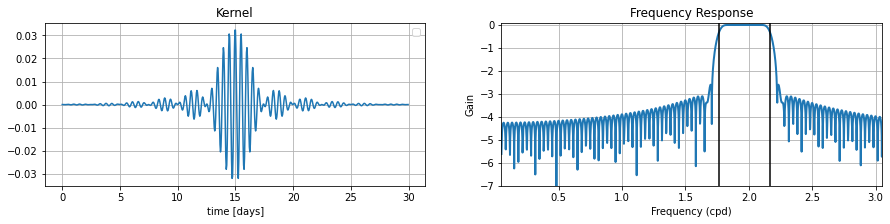

In [8]:
t = np.arange(0,30,dt)
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]

ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-dband, color='k')
ax.axvline(omega+dband, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [9]:
# generate synthetic data
#T,T_low = [14,29,80],10

def rename_attrs(da, **kwargs):
    """ rename attributes
    """
    for k_new, k_old in kwargs.items():
        da = da.assign_attrs(**{k_new: da.attrs.pop(k_old)})
    return da

def tseries(kind, params={}, **kwargs):
    _kwargs = dict(time=(t_size, 1/24), 
                   seed=0,
                  )
    _kwargs.update(**kwargs)
    #               T=10.,
    if kind=="high_M2":
        p = dict(U=[1.], T=T, sigma=omega_M2*rad) #[0.01, 0.05,.1, 1.]
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
#        da = (#rename_attrs(da, T_high="T")
#              da.rename(U='U_high')
#            )
    elif kind=="high_S2":
        p = dict(U=[1.], T=T, sigma=omega_S2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
#        da = (#rename_attrs(da, T_high="T")
#              da.rename(U='U_high')
#             )
    elif kind=="high_N2":
        p = dict(U=[0.01, 0.05,.1, 1.], T=T, sigma=omega_N2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = (#rename_attrs(da, T_high="T")
              da.rename(U='U_high')
             )
    elif kind=="high_K2":
        p = dict(U=[0.01, 0.05,.1, 1.], T=T, sigma=omega_K2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = (#rename_attrs(da, T_high="T")
              da.rename(U='U_high')
             )
    else:
        p = dict(T=T_low)
        p.update(**params)
        da = (u_low
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = rename_attrs(da, U_low="U") #T_low="T"
    return da

In [10]:
def autocorrelations(ds, V,combine=False,maxlag=None,lags=None,**kwargs):
#    V = ["high", "low"]
#    if combine:
#        ds["sum"] = ds["high"]  + ds["low"]
#        ds["sum_demodulated"] = ds["high_demodulated"]  + ds["low_demodulated"]
#        V = V + ["sum"]
    R = []
    for v in V:
        if v=='low':
            R.append((sigp
                  .correlate(ds[v].real, ds[v].real,maxlag=maxlag,lags=lags,**kwargs)
                  .rename(v)
                  .to_dataset()
                  .rename({'lags': 'tau'})
                 )
                )
        else:
            R.append((sigp
                      .correlate(ds[v+"_demodulated"].real, ds[v+"_demodulated"].real,maxlag=maxlag,lags=lags,**kwargs)
                      .rename(v)
                      .to_dataset()
                      .rename({'lags': 'tau'})
                     )
                    )
    return xr.merge(R)

In [12]:
t_size=500
T,T_low = [5,15,30,80],[5,15,30]
U_high = [0.1]#[0.01,0.05,0.1,1.]
Tw = [30]#[15,30,60]
dband = [0.05,0.1,0.2,0.3]
nb_draws = 500

### Coherent signal : 

In [13]:
u = hf.high_frequency_signal(stationary=True)

In [15]:
rad = 2*np.pi
p = dict(U=0., Us=1., sigma=omega_M2*rad)

u_M2 = u.generate_tseries(params=p, 
                         seed=0,
                         time=(t_size,1/24),
                         draws=nb_draws,name='M2_coh'
                        ).compute()


p = dict(U=0., Us=1., sigma=omega_S2*rad)

u_S2 = u.generate_tseries(params=p, 
                         seed=1,
                         time=(t_size,1/24),
                         draws=nb_draws,name='S2_coh'
                        ).compute()

u_low = hf.low_frequency_signal()
p = dict(U=1.)

low = u_low.generate_tseries(params=p, seeed=0,T=10,time=(t_size,1/24),draws=nb_draws).rename('low_signal').compute()
low


# = tseries("low",draws=nb_draws,T=T_low,time=(t_size,1/24),name='low_signal').compute()

<xarray.DataArray 'low_signal' (time: 12000, draw: 500)>
array([[ 0.05202007,  0.02746288, -0.06419854, ...,  0.11223016,
         0.00557256,  0.08011634],
       [-0.04742828, -0.00721683, -0.13718258, ...,  0.17031932,
         0.002755  ,  0.09615846],
       [-0.00944587,  0.03666499, -0.21020629, ...,  0.16788173,
         0.1081324 ,  0.14805077],
       ...,
       [-1.18962209, -0.7318049 , -0.8550061 , ...,  2.05153384,
         0.40798625,  1.12916736],
       [-1.26051715, -0.6758464 , -0.7914192 , ...,  1.84458347,
         0.53517725,  1.06498694],
       [-1.09973827, -0.53333602, -0.73892065, ...,  1.76211064,
         0.43986065,  1.19618325]])
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Attributes:
    T:        10
    U:        1.0

In [16]:
u_high = u_S2+u_M2
u_total = u_S2+u_M2+low

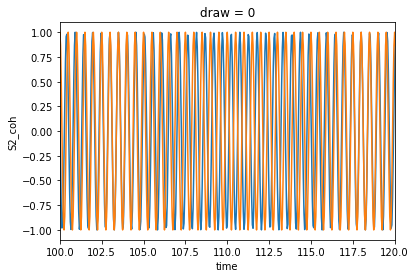

In [18]:
u_M2.sel(draw=0).plot(xlim=(100,120))
u_S2.sel(draw=0).plot(xlim=(100,120))

In [36]:
u=hf.high_frequency_signal(stationary=False)

p = dict(U=1., sigma=omega_M2*rad,T=T) #, Us=0.

u_M2_inc = u.generate_tseries(params=p, 
                         seed=2,
                         time=(t_size,1/24),
                         draws=nb_draws,chunks={'draw':200}
                        ).rename('M2_inc').compute()


p = dict(U=1., sigma=omega_S2*rad,T=T) #, Us=0.

u_S2_inc = u.generate_tseries(params=p, 
                         seed=3,
                         time=(t_size,1/24),
                         draws=nb_draws,chunks={'draw':200}
                        ).rename('S2_inc').compute()

# = tseries("low",draws=nb_draws,T=T_low,time=(t_size,1/24),name='low_signal').compute()

In [40]:
u_high_inc = u_M2_inc+u_S2_inc
u_total_inc = u_M2_inc+u_S2_inc+low

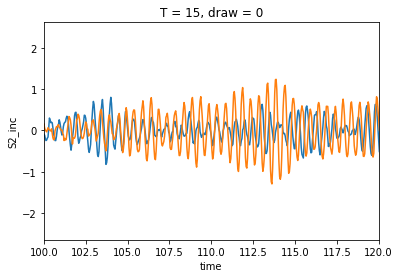

In [41]:
u_M2_inc.sel(draw=0,T=15).plot(xlim=(100,120))
u_S2_inc.sel(draw=0,T=15).plot(xlim=(100,120))

In [23]:
u=hf.high_frequency_signal(stationary=True)

p = dict(U=.5, Us=0.5, sigma=omega_M2*rad,T=T)

u_M2_mix = u.generate_tseries(params=p, 
                         seed=4,
                         time=(t_size,1/24),
                         draws=nb_draws,chunks={'draw':200}
                        ).rename('M2_mix').compute()


p = dict(U=.5, Us=0.5, sigma=omega_S2*rad,T=T)

u_S2_mix = u.generate_tseries(params=p, 
                         seed=5,
                         time=(t_size,1/24),
                         draws=nb_draws,chunks={'draw':200}
                        ).rename('S2_mix').compute()

In [24]:
u_high_mix = u_M2_mix+u_S2_mix
u_total_mix = u_M2_mix+u_S2_mix+low

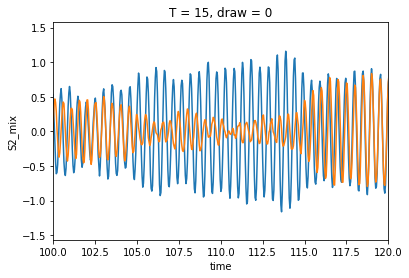

In [25]:
u_M2_mix.sel(draw=0,T=15).plot(xlim=(100,120))
u_S2_mix.sel(draw=0,T=15).plot(xlim=(100,120))

In [42]:
ds = xr.Dataset({'M2_coh':u_M2,'S2_coh':u_S2,'high_MS_coh':u_high.rename('u_high'),
                'M2_mix':u_M2_mix,'S2_mix':u_S2_mix,'high_MS_mix':u_high_mix.rename('u_high'),
                'M2_inc':u_M2_inc,'S2_inc':u_S2_inc,'high_MS_inc':u_high_inc.rename('u_high')
                })
ds

<xarray.Dataset>
Dimensions:      (time: 12000, draw: 500, T: 4)
Coordinates:
  * time         (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * T            (T) int64 5 15 30 80
Data variables:
    M2_coh       (time, draw) float64 1.0 1.0 1.0 1.0 ... 0.9381 0.9381 0.9381
    S2_coh       (time, draw) float64 1.0 1.0 1.0 1.0 ... 0.866 0.866 0.866
    high_MS_coh  (time, draw) float64 2.0 2.0 2.0 2.0 ... 1.804 1.804 1.804
    M2_mix       (T, time, draw) float64 0.5023 0.5228 0.4545 ... 0.5072 0.3125
    S2_mix       (T, time, draw) float64 0.5201 0.4849 0.6109 ... 0.7656 0.4774
    high_MS_mix  (T, time, draw) float64 1.022 1.008 1.065 ... 1.273 0.7898
    M2_inc       (T, time, draw) float64 -0.03804 -0.005136 ... -0.9903 0.1841
    S2_inc       (T, time, draw) float64 0.1633 0.03985 ... 0.01148 0.3254
    high_MS_inc  (T, time, draw) float64 0.1252 0.03471 ... -0.9788 0.5095

In [43]:
ds_filtered = {}
for k in ds:
    if k[:2]=='M2':
        om = omega_M2
    if k[:2]=='S2':
        om = omega_S2
    else:
        om = omega
    ds_filtered[k] = xr.concat([sigp_AP.bpass_demodulate(ds[k], om, dband, 30)[0] for dband in [0.1,0.2,0.3]],dim='bandwidth'
                              ).assign_coords({'bandwidth':[0.2,0.4,0.6]})
#ds_filtered

KeyboardInterrupt: 

In [28]:
for k in ds:    
    if k[-3:]=='coh':
        ds[k+'_complex'] = xr.DataArray(signal.hilbert(ds[k],axis=0),dims=["time","draw"])
        ds[k+'_demodulated'] = ds[k+'_complex']*ds_filtered[k].exp
    else:
        ds[k+'_complex'] = xr.DataArray(signal.hilbert(ds[k],axis=1),dims=["T","time","draw"])
        ds[k+'_demodulated'] = ds[k+'_complex']*ds_filtered[k].exp



(array([4.0000e+00, 5.0000e+00, 4.6000e+01, 1.1916e+04, 1.6000e+01,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0.88176461, 0.91739051, 0.9530164 , 0.9886423 , 1.02426819,
        1.05989408, 1.09551998, 1.13114587, 1.16677177, 1.20239766,
        1.23802356]),
 <BarContainer object of 10 artists>)

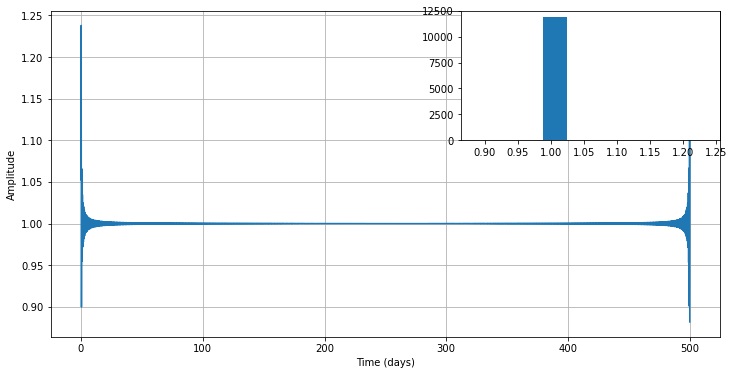

In [30]:
s = np.abs((ds.M2_coh_demodulated)**2).mean('draw')
fig = plt.figure(figsize=(12,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = np.abs((ds.high_MS_coh_demodulated)**2).mean('draw')
fig = plt.figure(figsize=(12,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

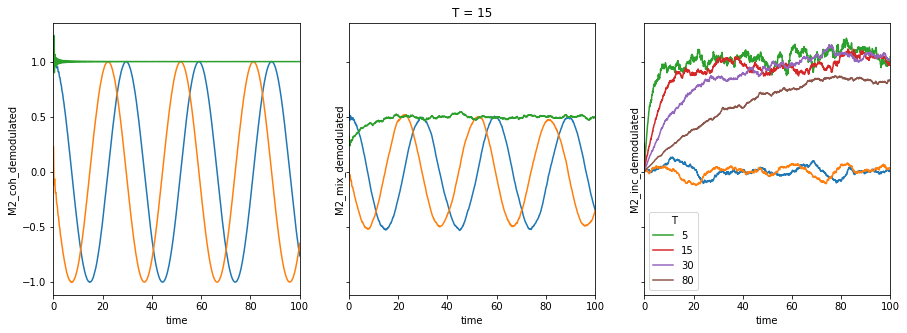

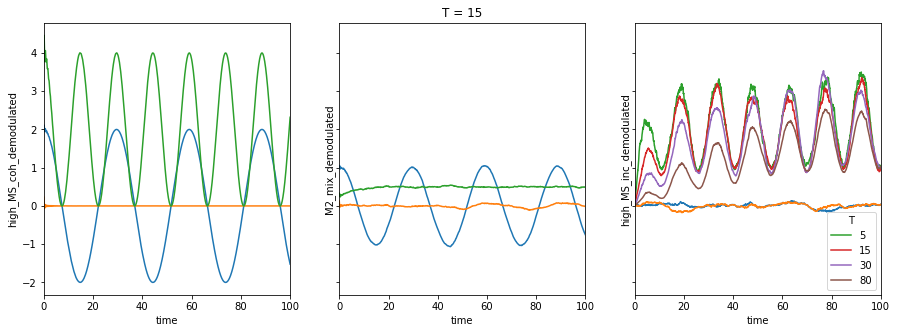

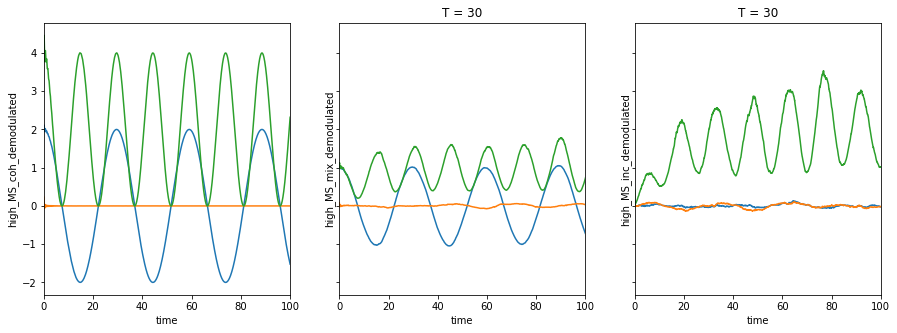

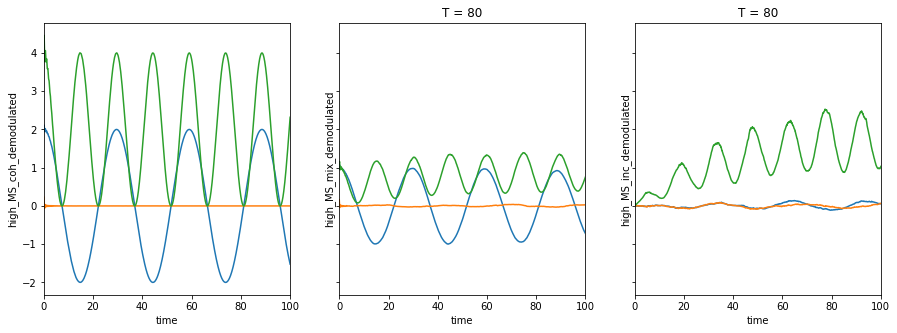

In [38]:
delta_T = 100
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.M2_coh_demodulated.real.mean('draw').plot(ax=axs[0],xlim=(0,delta_T))
ds.M2_coh_demodulated.imag.mean('draw').plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.M2_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.M2_mix_demodulated.real.mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
ds.M2_mix_demodulated.imag.mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.M2_mix_demodulated)**2).mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))

ds.M2_inc_demodulated.real.mean('draw').sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
ds.M2_inc_demodulated.imag.mean('draw').sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.M2_inc_demodulated)**2).mean('draw').plot(ax=axs[2],xlim=(0,delta_T),hue='T')

fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.high_MS_coh_demodulated.mean('draw').real.plot(ax=axs[0],xlim=(0,delta_T))
ds.high_MS_coh_demodulated.mean('draw').imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.high_MS_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.high_MS_mix_demodulated.mean('draw').real.sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
ds.high_MS_mix_demodulated.mean('draw').imag.sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.M2_mix_demodulated)**2).mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))

ds.high_MS_inc_demodulated.mean('draw').real.sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
ds.high_MS_inc_demodulated.mean('draw').imag.sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.high_MS_inc_demodulated)**2).mean('draw').plot(ax=axs[2],xlim=(0,delta_T),hue='T')

fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.high_MS_coh_demodulated.mean('draw').real.plot(ax=axs[0],xlim=(0,delta_T))
ds.high_MS_coh_demodulated.mean('draw').imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.high_MS_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.high_MS_mix_demodulated.mean('draw').real.sel(T=30).plot(ax=axs[1],xlim=(0,delta_T))
ds.high_MS_mix_demodulated.mean('draw').imag.sel(T=30).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.high_MS_mix_demodulated)**2).mean('draw').sel(T=30).plot(ax=axs[1],xlim=(0,delta_T))

ds.high_MS_inc_demodulated.mean('draw').real.sel(T=30).plot(ax=axs[2],xlim=(0,delta_T))
ds.high_MS_inc_demodulated.mean('draw').imag.sel(T=30).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.high_MS_inc_demodulated)**2).mean('draw').sel(T=30).plot(ax=axs[2],xlim=(0,delta_T))

fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.high_MS_coh_demodulated.mean('draw').real.plot(ax=axs[0],xlim=(0,delta_T))
ds.high_MS_coh_demodulated.mean('draw').imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.high_MS_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.high_MS_mix_demodulated.mean('draw').real.sel(T=80).plot(ax=axs[1],xlim=(0,delta_T))
ds.high_MS_mix_demodulated.mean('draw').imag.sel(T=80).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.high_MS_mix_demodulated)**2).mean('draw').sel(T=80).plot(ax=axs[1],xlim=(0,delta_T))

ds.high_MS_inc_demodulated.mean('draw').real.sel(T=80).plot(ax=axs[2],xlim=(0,delta_T))
ds.high_MS_inc_demodulated.mean('draw').imag.sel(T=80).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.high_MS_inc_demodulated)**2).mean('draw').sel(T=80).plot(ax=axs[2],xlim=(0,delta_T))

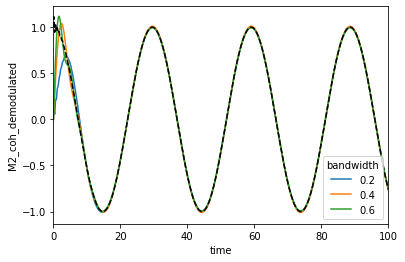

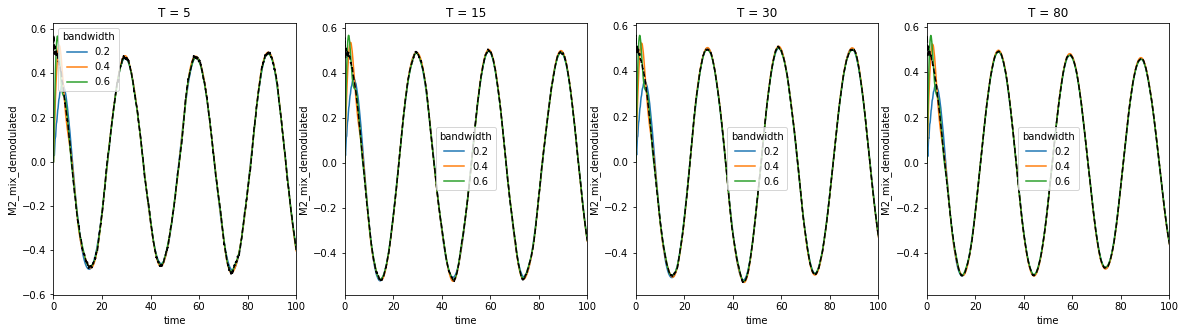

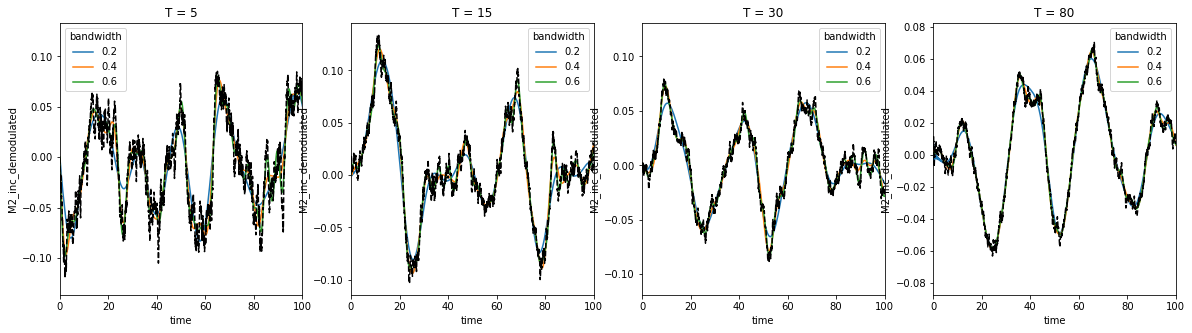

In [39]:
ds_filtered['M2_coh'].demodulated.mean('draw').real.plot(xlim=(0,delta_T),hue='bandwidth')
ds.M2_coh_demodulated.mean('draw').real.plot(c='k',linestyle='--',xlim=(0,delta_T))
fig,axs = plt.subplots(1,ds.T.size,figsize=(5*ds.T.size,5))
for ax ,t in zip(axs,ds.T):
    ds_filtered['M2_mix'].demodulated.mean('draw').real.sel(T=t).plot(ax=ax,xlim=(0,delta_T),hue='bandwidth')
    ds.M2_mix_demodulated.mean('draw').real.sel(T=t).plot(ax=ax,c='k',linestyle='--',xlim=(0,delta_T))

fig,axs = plt.subplots(1,ds.T.size,figsize=(5*ds.T.size,5))
for ax ,t in zip(axs,ds.T):
    ds_filtered['M2_inc'].demodulated.mean('draw').real.sel(T=t).plot(ax=ax,xlim=(0,delta_T),hue='bandwidth')
    ds.M2_inc_demodulated.mean('draw').real.sel(T=t).plot(ax=ax,c='k',linestyle='--',xlim=(0,delta_T))

In [93]:
ds_filtered['M2_coh'].demodulated.real.mean('draw')

<xarray.DataArray 'demodulated' (bandwidth: 3, time: 12000)>
array([[ 7.54683545e-10,  9.43415838e-02,  1.28612472e-01, ...,
         9.88973021e-02,  5.79307074e-02, -1.99162802e-02],
       [ 3.09159729e-09,  6.47760742e-02,  9.87018960e-02, ...,
         8.10057289e-02,  3.69714191e-02, -1.61597619e-02],
       [ 7.08552519e-09,  5.83595948e-02,  1.00107718e-01, ...,
         8.63857223e-02,  3.38337468e-02, -1.44799908e-02]])
Coordinates:
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
    exp        (time) complex128 (1+0j) ... (0.9963946710000068+0.08483902169...
  * bandwidth  (bandwidth) float64 0.2 0.4 0.6

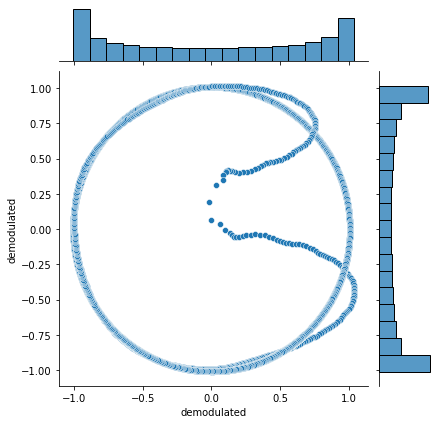

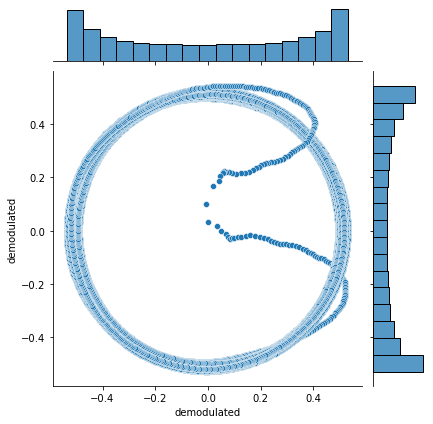

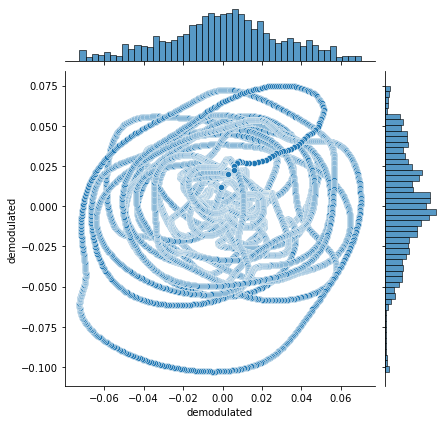

In [97]:
import seaborn as sns
sns.jointplot(x = ds_filtered['M2_coh'].demodulated.real.mean('draw').sel(bandwidth=0.4),y=ds_filtered['M2_coh'].demodulated.imag.mean('draw').sel(bandwidth=0.4),kind="scatter")

sns.jointplot(x = ds_filtered['M2_mix'].demodulated.real.mean('draw').sel(bandwidth=0.4,T=80),y=ds_filtered['M2_mix'].demodulated.imag.mean('draw').sel(bandwidth=0.4,T=80),kind="scatter")

sns.jointplot(x = ds_filtered['M2_inc'].demodulated.real.mean('draw').sel(bandwidth=0.4,T=80),y=ds_filtered['M2_inc'].demodulated.imag.mean('draw').sel(bandwidth=0.4,T=80),kind="scatter")

(array([4.0000e+00, 5.0000e+00, 4.6000e+01, 1.1916e+04, 1.6000e+01,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0.88176461, 0.91739051, 0.9530164 , 0.9886423 , 1.02426819,
        1.05989408, 1.09551998, 1.13114587, 1.16677177, 1.20239766,
        1.23802356]),
 <BarContainer object of 10 artists>)

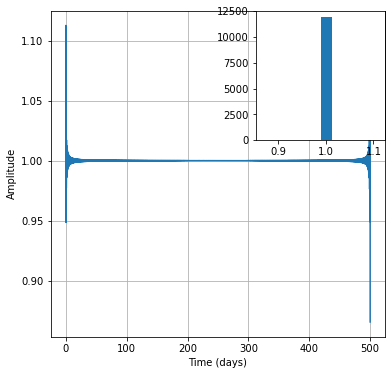

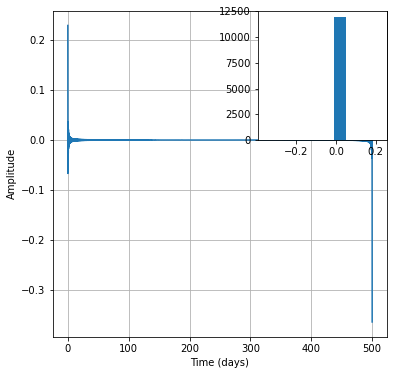

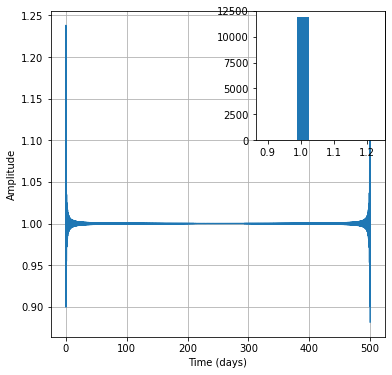

In [95]:
s = ds.M2_coh_demodulated.real.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = ds.M2_coh_demodulated.imag.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = np.abs((ds.M2_coh_demodulated)**2).mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

(array([2611., 1164.,  956.,  879.,  858.,  881.,  961., 1156., 2525.,
           9.]),
 array([5.57766610e-08, 4.46081224e-01, 8.92162392e-01, 1.33824356e+00,
        1.78432473e+00, 2.23040590e+00, 2.67648706e+00, 3.12256823e+00,
        3.56864940e+00, 4.01473057e+00, 4.46081174e+00]),
 <BarContainer object of 10 artists>)

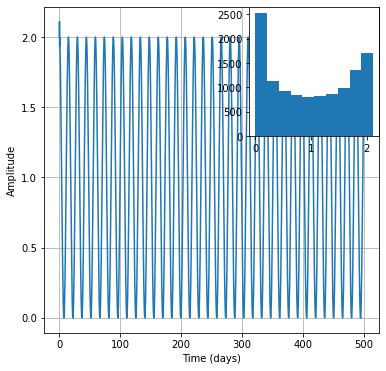

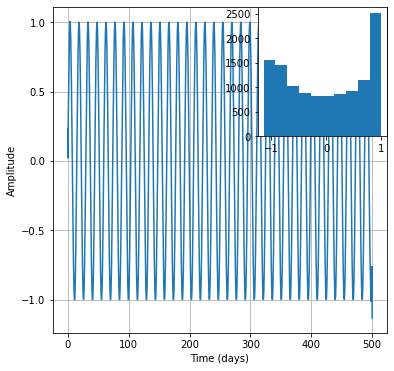

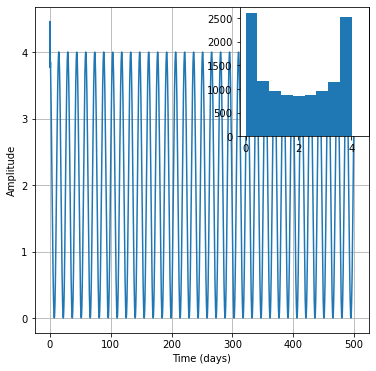

In [96]:
s = ds.high_MS_coh_demodulated.real.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = ds.high_MS_coh_demodulated.imag.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = np.abs((ds.high_MS_coh_demodulated)**2).mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

In [40]:
for k in ds:
    print(k)

M2_coh
S2_coh
high_MS_coh
M2_mix
S2_mix
high_MS_mix
M2_inc
S2_inc
high_MS_inc
M2_coh_complex
M2_coh_demodulated
S2_coh_complex
S2_coh_demodulated
high_MS_coh_complex
high_MS_coh_demodulated


<xarray.DataArray 'M2_mix' (T: 4, time: 12000, draw: 500)>
array([[[ 0.48097769,  0.49743178,  0.40249643, ...,  0.49008918,
          0.55356414,  0.39302964],
        [ 0.34280249,  0.40520294,  0.34517666, ...,  0.44319674,
          0.53377855,  0.29577327],
        [ 0.14709394,  0.23847941,  0.16242037, ...,  0.29303599,
          0.27065344,  0.0948911 ],
        ...,
        [ 0.63114368, -0.74944564,  0.22171349, ...,  0.38427335,
          0.35884655,  0.32131512],
        [ 0.84257254, -0.50109783, -0.14593783, ...,  0.17744272,
          0.60702401,  0.26841609],
        [ 0.81792619, -0.02342099, -0.4377151 , ..., -0.06755619,
          0.56941079,  0.21089767]],

       [[ 0.51738992,  0.45279276,  0.49723836, ...,  0.50999611,
          0.50185642,  0.48859928],
        [ 0.43021637,  0.3595511 ,  0.35275964, ...,  0.45434805,
          0.35660004,  0.41717049],
        [ 0.24962032,  0.21392259,  0.16394051, ...,  0.31144289,
          0.15390115,  0.25646177],
...
        [ 0.27261617,  0.50160283, -0.07244384, ..., -0.17986753,
         -0.36770758,  0.61814493],
        [ 0.20965655,  0.50794996,  0.00499468, ..., -0.02834155,
         -0.43157646,  0.66783176],
        [ 0.09020007,  0.36893995,  0.09134312, ...,  0.12783353,
         -0.39400928,  0.52702565]],

       [[ 0.50027282,  0.51448244,  0.47046603, ...,  0.48778655,
          0.49805674,  0.49189422],
        [ 0.43186806,  0.46385175,  0.44369861, ...,  0.41710469,
          0.44486732,  0.45306352],
        [ 0.266145  ,  0.27968728,  0.28061556, ...,  0.24071803,
          0.28246965,  0.2853744 ],
        ...,
        [ 0.02905515,  0.68900413,  0.36102291, ...,  0.28916456,
         -0.05001233,  0.66650003],
        [-0.06037316,  0.84322145,  0.46640305, ...,  0.48896912,
         -0.05214855,  0.70808011],
        [-0.12901999,  0.75588039,  0.47180875, ...,  0.56270226,
         -0.02608224,  0.56108967]]])
Coordinates:
  * time         (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * T            (T) int64 5 15 30 80
    bpassed      (T, draw, time) complex128 (1.5822584676546587e-09-0.0121059...
    demodulated  (T, draw, time) complex128 (1.5822584676546587e-09-0.0121059...
    exp          (time) complex128 (1+0j) ... (0.938091840770205-0.3463866312...
Attributes:
    U:        0.5
    sigma:    12.140833182614747

NameError: name 's' is not defined

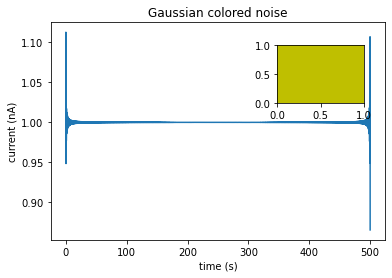

In [76]:
kind  = ['M2','S2','high_MS','total']
_ds_stat = {}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds_stat[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})#.compute()

In [51]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
rect = [0.2,0.2,0.7,0.7]
inax_position  = ax.transAxes.transform(rect[0:2])
transFigure = fig.transFigure.inverted()
infig_position = transFigure.transform(inax_position)    
x = infig_position[0]
y = infig_position[1]


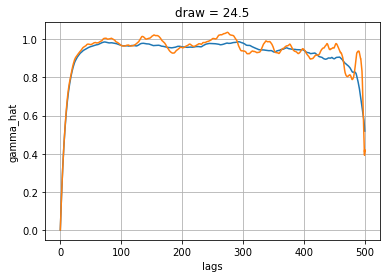

In [54]:
dsw.gamma_hat.mean('draw').plot()
dsw.gamma_hat.isel(draw=0).plot()
plt.grid()

In [20]:
u_total = u_total.rename('total')
u_high = u_high.rename('high')

In [ ]:
ds_high = sigp_AP.svariance(u_high,"time").rename("gammma_hat").to_dataset()
dsw_high = ds_high.coarsen(int(t_size/10)).mean()


In [27]:
ds_total = sigp_AP.svariance(u_total, "time").rename("gamma_hat").to_dataset()

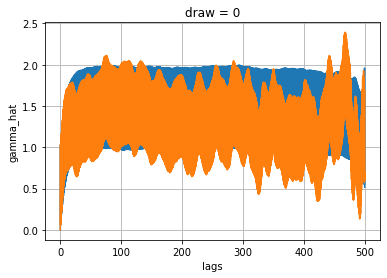

In [28]:
ds_total.gamma_hat.mean('draw').plot()
ds_total.gamma_hat.sel(draw=0).plot()
plt.grid()

In [30]:
dsw_total = ds_total.coarsen(draw = int(t_size/10)).mean()

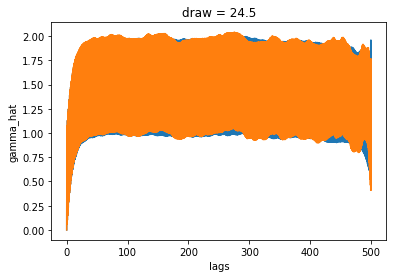

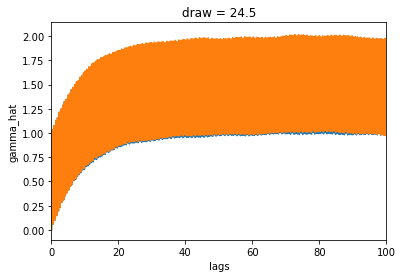

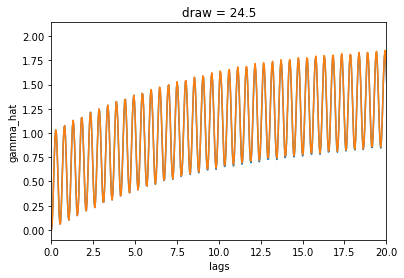

In [33]:
dsw_total.gamma_hat.mean('draw').plot()
dsw_total.gamma_hat.isel(draw=0).plot()

plt.figure()
dsw_total.gamma_hat.mean('draw').plot(xlim=(0,100))
dsw_total.gamma_hat.isel(draw=0).plot(xlim=(0,100))
plt.figure()
dsw_total.gamma_hat.mean('draw').plot(xlim=(0,20))
dsw_total.gamma_hat.isel(draw=0).plot(xlim=(0,20))

In [22]:
u_high_filtered = sigp_AP.bpass_demodulate(u_high,omega,0.2,30)
u_total_filtered = sigp_AP.bpass_demodulate(u_total,omega,0.2,30)

In [27]:
ds_demodulated = sigp_AP.svariance(u_total_filtered[0].demodulated.real, "time").rename("gamma_hat").to_dataset()

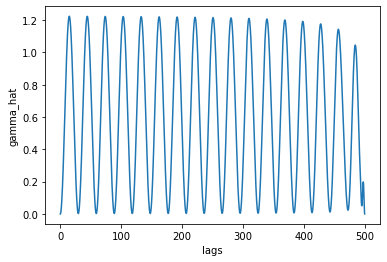

In [29]:
ds_demodulated.gamma_hat.mean('draw').plot()

In [43]:
rad = 2*np.pi
p = dict(U=0.5, Us=.5, T=10., sigma=omega_M2*rad)

u_M2 = u.generate_tseries(params=p, 
                         seed=0,
                         time=(t_size,1/24),
                         draws=nb_draws,name='M2'
                        ).compute()


p = dict(U=0.5, Us=.5, T=10., sigma=omega_S2*rad)

u_S2 = u.generate_tseries(params=p, 
                         seed=0,
                         time=(t_size,1/24),
                         draws=nb_draws,name='S2'
                        ).compute()

u_low = hf.low_frequency_signal()
low = tseries("low",draws=nb_draws,name='low').compute()

In [44]:
u_high = u_M2+u_S2
u_total = u_M2+u_S2+low

In [45]:
u_high = u_high.rename('high')
u_total = u_total.rename('total')

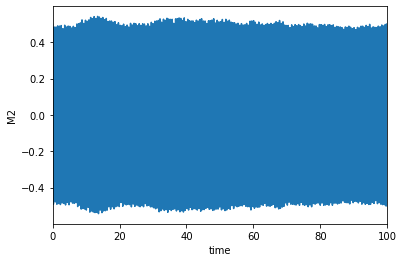

In [56]:
u_M2.mean('draw').plot(xlim=(0,100))

In [34]:
ds_high = sigp_AP.svariance(u_high,"time").rename("gammma_hat").to_dataset()
#dsw_high = ds_high.coarsen(int(t_size/10)).mean()

In [36]:
ds_high

<xarray.Dataset>
Dimensions:     (draw: 500, lags: 12000)
Coordinates:
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * lags        (lags) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
    N           (lags) int64 12000 11999 11998 11997 11996 11995 ... 5 5 4 2 2 1
Data variables:
    gammma_hat  (draw, lags) float64 0.0 0.05064 0.1858 ... 1.087 1.202 1.098

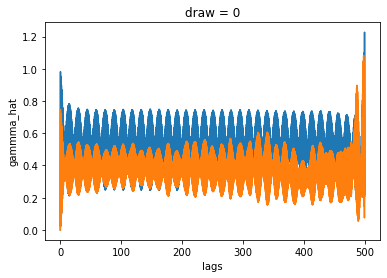

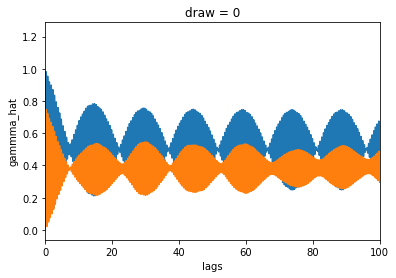

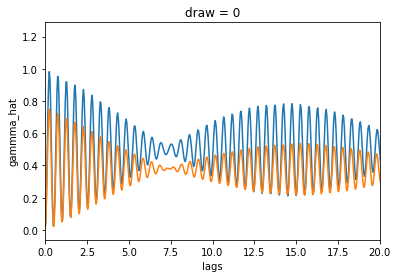

In [37]:
ds_high.gammma_hat.mean('draw').plot()
ds_high.gammma_hat.sel(draw=0).plot()

plt.figure()
ds_high.gammma_hat.mean('draw').plot(xlim=(0,100))
ds_high.gammma_hat.sel(draw=0).plot(xlim=(0,100))

plt.figure()
ds_high.gammma_hat.mean('draw').plot(xlim=(0,20))
ds_high.gammma_hat.sel(draw=0).plot(xlim=(0,20))

In [46]:
u_high_filtered = sigp_AP.bpass_demodulate(u_high,omega,0.2,30)
u_total_filtered = sigp_AP.bpass_demodulate(u_total,omega,0.2,30)

In [47]:
ds_total = sigp_AP.svariance(u_total_filtered[0].demodulated.real,"time").rename("gamma_hat").to_dataset()

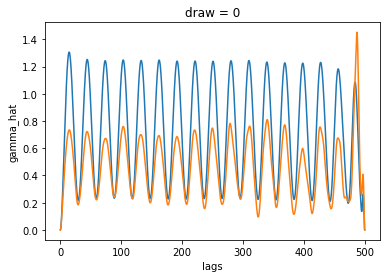

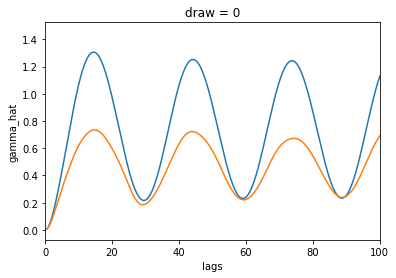

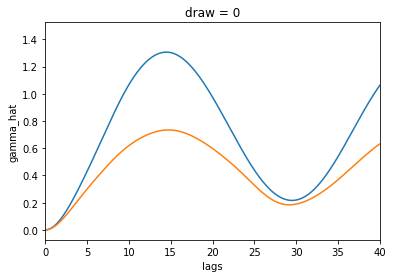

In [48]:
ds_total.gamma_hat.mean('draw').plot()
ds_total.gamma_hat.sel(draw=0).plot()

plt.figure()
ds_total.gamma_hat.mean('draw').plot(xlim=(0,100))
ds_total.gamma_hat.sel(draw=0).plot(xlim=(0,100))

plt.figure()
ds_total.gamma_hat.mean('draw').plot(xlim=(0,40))
ds_total.gamma_hat.sel(draw=0).plot(xlim=(0,40))

In [50]:
dsw_total = ds_total.coarsen(draw=int(t_size/10)).mean()

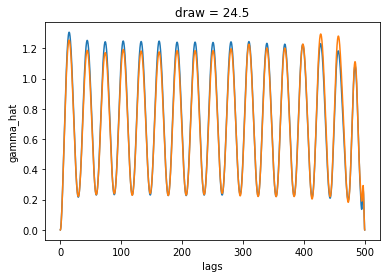

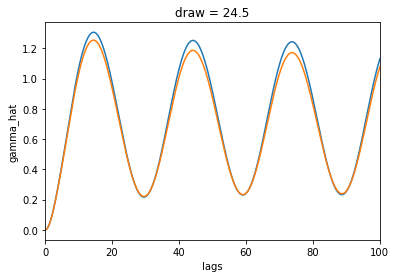

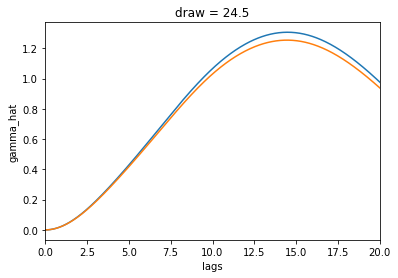

In [52]:
dsw_total.gamma_hat.mean('draw').plot()
dsw_total.gamma_hat.isel(draw=0).plot()

plt.figure()
dsw_total.gamma_hat.mean('draw').plot(xlim=(0,100))
dsw_total.gamma_hat.isel(draw=0).plot(xlim=(0,100))

plt.figure()
dsw_total.gamma_hat.mean('draw').plot(xlim=(0,20))
dsw_total.gamma_hat.isel(draw=0).plot(xlim=(0,20))

In [25]:
kind = ['M2','S2','high','total'] #'high_MSNK',
_ds,h = {},{}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})
    h[k] = [[sigp.bpass_demodulate(ds[[k]], om, band, tw)[1] for tw in Tw] for band in dband]

In [18]:
ds = xr.merge([u_M2,u_S2,u_high.rename('high'),u_total.rename('total')])
ds

<xarray.Dataset>
Dimensions:  (T: 3, draw: 30, time: 24000)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
  * T        (T) int64 5 30 100
Data variables:
    M2       (time, draw) float64 dask.array<chunksize=(24000, 30), meta=np.ndarray>
    S2       (time, draw) float64 dask.array<chunksize=(24000, 30), meta=np.ndarray>
    high     (time, draw) float64 dask.array<chunksize=(24000, 30), meta=np.ndarray>
    total    (time, draw, T) float64 dask.array<chunksize=(24000, 30, 3), meta=np.ndarray>

In [19]:
kind = ['M2','S2','high','total'] #'high_MSNK',
_ds,h = {},{}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})
    h[k] = [[sigp.bpass_demodulate(ds[[k]], om, band, tw)[1] for tw in Tw] for band in dband]



In [22]:
R = {}
maxlag=1000
lags= np.arange(0,maxlag//2,1/24)
#kind = ['high_M2','high_S2','high_MS','high_MSNK','total']
for k in kind:
    R[k] = autocorrelations(_ds[k],[k],maxlag=None,lags = lags,**{'mode':'same'})

In [23]:
ds_R = xr.merge([R[k] for k in kind])

In [24]:
ds_R_mean = ds_R.mean('draw').compute()

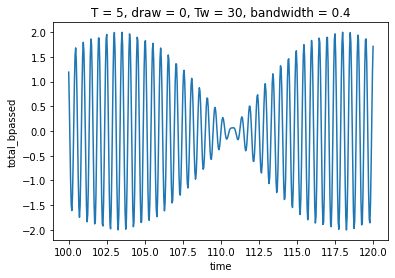

In [25]:
_ds['total'].total_bpassed.real.sel(draw=0,Tw=30,T=5,bandwidth=0.4).sel(time=slice(100,120)).plot()

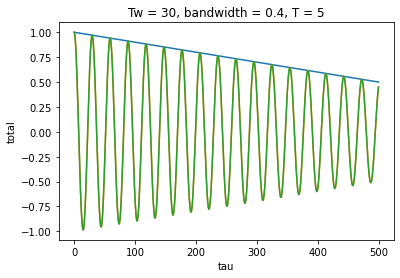

In [26]:
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean.high/ds_R_mean.high.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean.total/ds_R_mean.total.isel(tau=0)).sel(bandwidth=0.4,Tw=30,T=5).plot()

Notes : 
Pas de contamination par la basse fréquence.

In [27]:
R_valid = {}
maxlag=1000
lags= np.arange(0,maxlag//2,1/24)
#kind = ['high_M2','high_S2','high_MS','high_MSNK','total']
for k in kind:
    R_valid[k] = autocorrelations(_ds[k],[k],maxlag=maxlag,lags = lags,**{'mode':'valid'})

In [28]:
ds_R_valid = xr.merge([R_valid[k] for k in kind])

In [29]:
ds_R_mean_valid = ds_R_valid.mean('draw').compute()

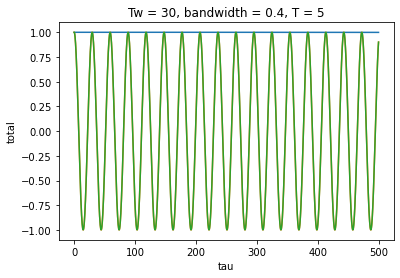

In [30]:
(ds_R_mean_valid.M2/ds_R_mean_valid.M2.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean_valid.high/ds_R_mean_valid.high.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean_valid.total/ds_R_mean_valid.total.isel(tau=0)).sel(bandwidth=0.4,Tw=30,T=5).plot()

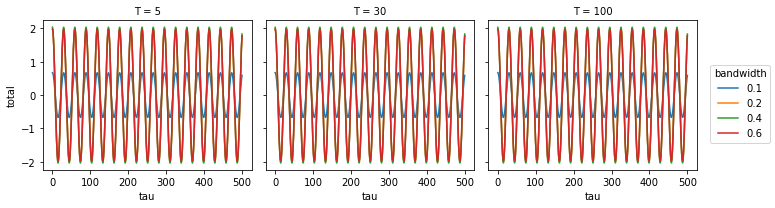

In [35]:
ds_R_mean_valid.total.sel(Tw=30).plot(col='T',hue='bandwidth')

In [31]:
ds_R_mean.to_netcdf('/Users/zcaspar/codes/mit4320/synthetic_30_same.nc')
ds_R_mean_valid.to_netcdf('/Users/zcaspar/codes/mit4320/synthetic_30_valid.nc')

###  Incoherent signal : 1 draw

In [12]:
# actually generate time series

u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()
da_high_M2 = tseries("high_M2",draws=1,name='high_M2').persist()
#da_high_M2 = da_high_M2.rename('high_M2')
da_high_S2 = tseries("high_S2",draws=1,name='high_S2').persist()
#da_high_S2 = da_high_S2.rename('high_S2')
#da_high_N2 = tseries("high_N2",draws=1).persist()
#da_high_N2 = da_high_N2.rename('high_N2')
#da_high_K2 = tseries("high_K2",draws=1).persist()
#da_high_K2 = da_high_K2.rename('high_K2')


da_low = tseries("low",draws=1).persist()

In [13]:
da_high_M2.attrs = {'sigma_M2':da_high_M2.attrs['sigma']}
da_high_S2.attrs = {'sigma_S2':da_high_S2.attrs['sigma']}

#da_high_N2.attrs = {'sigma_N2':da_high_N2.attrs['sigma']}
#da_high_K2.attrs = {'sigma_K2':da_high_K2.attrs['sigma']}

#ds = xr.merge([da_high_M2,da_high_S2,da_high_N2,da_high_K2, da_low.rename({'T':'T_low'})]) #, combine_attrs="no_conflicts"
#ds = xr.merge([da_high_M2,da_high_S2, da_low.rename({'T':'T_low'})])

#ds

In [14]:
da_high_M2 = xr.concat([da_high_M2*U for U in U_high],dim='U_high').assign_coords({'U_high':U_high})
da_high_S2 = xr.concat([da_high_S2*U for U in U_high],dim='U_high').assign_coords({'U_high':U_high})
ds = xr.merge([da_high_M2,da_high_S2, da_low.rename({'T':'T_low'})])
ds

<xarray.Dataset>
Dimensions:  (T: 5, T_low: 3, U_high: 4, time: 24000)
Coordinates:
  * T        (T) int64 5 10 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * T_low    (T_low) int64 5 30 100
Data variables:
    high_M2  (U_high, T, time) float64 dask.array<chunksize=(1, 5, 24000), meta=np.ndarray>
    high_S2  (U_high, T, time) float64 dask.array<chunksize=(1, 5, 24000), meta=np.ndarray>
    low      (T_low, time) float64 dask.array<chunksize=(3, 24000), meta=np.ndarray>

In [15]:
ds['high_MS'] = ds.high_M2+ds.high_S2
#ds['high_MSNK'] = ds.high_M2+ds.high_S2+ds.high_N2+ds.high_K2
ds['total'] = ds.high_M2+ds.high_S2+ds.low

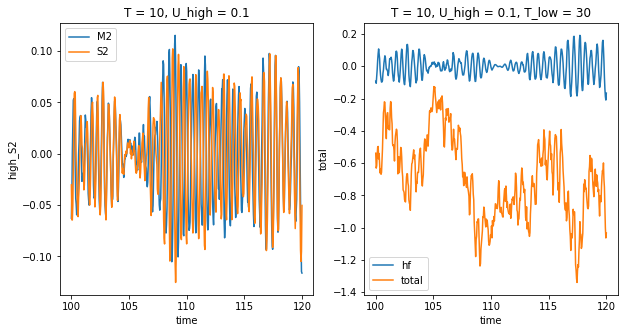

In [16]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ds.high_M2.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[0],label='M2')
ds.high_S2.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[0],label='S2')
ax[0].legend()
ds.high_MS.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[1],label='hf')
ds.total.isel(T_low=1,T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[1],label='total')
ax[1].legend()

#### Filter and demodulation : 
Band pass filter applied to signal : 
1) monochromatic signal, M2 frequency

2) monochromatic signal, S2 frequency 

3) superpostion of S2 and M2 ; central frequency is the mean frequency

4) total signal (M2+S2+lf) ; central frequency is the mean frequency

Notes on paramters : 

1) halfbandwidth, $d\omega$, should be defined such as : $1/d\omega\geq T_w$; where $T_w$ is the kernel length

2) $d\omega\geq \tilde T$ ; where $\tilde T$ is the hf decorrelation timescale.

In [17]:

kind = ['high_M2','high_S2','high_MS','total'] #'high_MSNK',
_ds,h = {},{}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})
    h[k] = [[sigp.bpass_demodulate(ds[[k]], om, band, tw)[1] for tw in Tw] for band in dband]


In [18]:
_ds['low'] = ds.low

In [19]:
maxlag=t_size
lags= np.arange(0,maxlag//2,1/24)
R = {}
#kind = ['high_M2','high_S2','high_MS','high_MSNK','total']
for k in kind:
    R[k] = autocorrelations(_ds[k],[k],maxlag = maxlag,lags=lags,**{'mode':'valid'})

In [20]:
ds_R = xr.merge([R[k] for k in kind])

In [21]:
ds_R = ds_R.compute()

In [26]:
R_low = autocorrelations(_ds,['low'],maxlag=maxlag,lags=lags,**{'mode':'valid'})
dsR_low = R_low.compute()

In [27]:
ds_R = xr.merge([ds_R,dsR_low])

In [28]:
#ds_R.to_netcdf('/home1/datawork/zcaspar/mit4320/synthetic_1.nc')
ds_R.to_netcdf('/Users/zcaspar/codes/mit4320/synthetic_1_U.nc')

#### Monochromatic signal ,M2

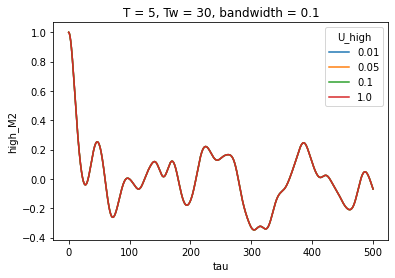

<Figure size 432x288 with 0 Axes>

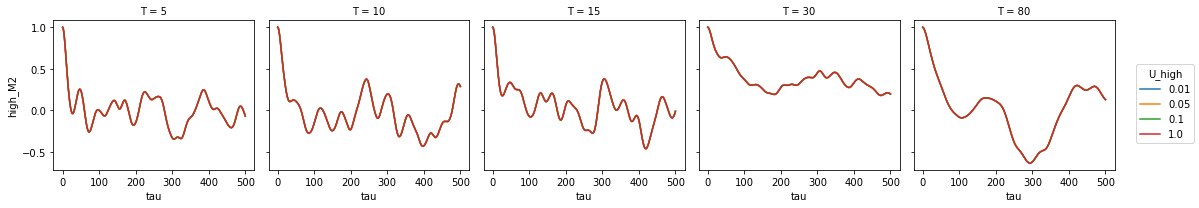

<Figure size 432x288 with 0 Axes>

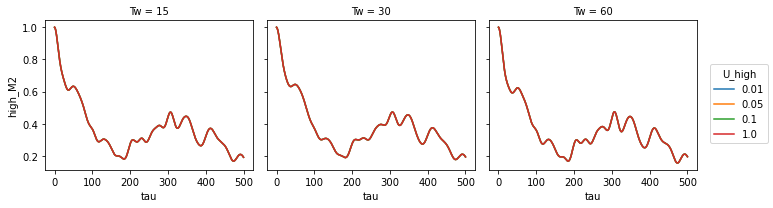

<Figure size 432x288 with 0 Axes>

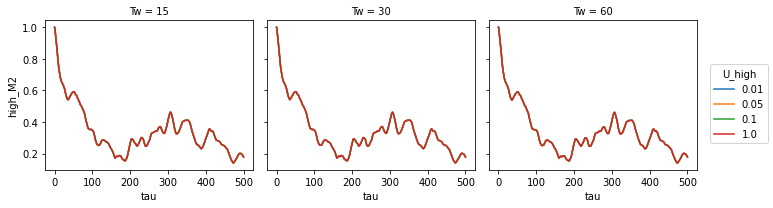

<Figure size 432x288 with 0 Axes>

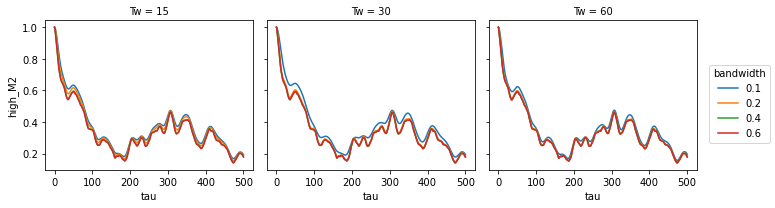

In [30]:
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,T=5,Tw=30).plot(hue='U_high')
plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,Tw=30).plot(hue='U_high',col='T')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,T=30).plot(hue='U_high',col='Tw')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.6,T=30).plot(hue='U_high',col='Tw')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(T=30,U_high=0.1).plot(hue='bandwidth',col='Tw')

Notes : 

For large enough bandwidth compared to the decorrelation timescale, kernel length and bandwidth do not have impact on the results.

The form of autocovariance changes depending on the amplitude (mean over several samples should correct this).

NB : Short decorrealtion timescale compared to the band width ($\tilde T\leq T_\omega$) introduces oscillations in the autocovariance (expected)

#### High frequency signal (M2+S2)

<Figure size 432x288 with 0 Axes>

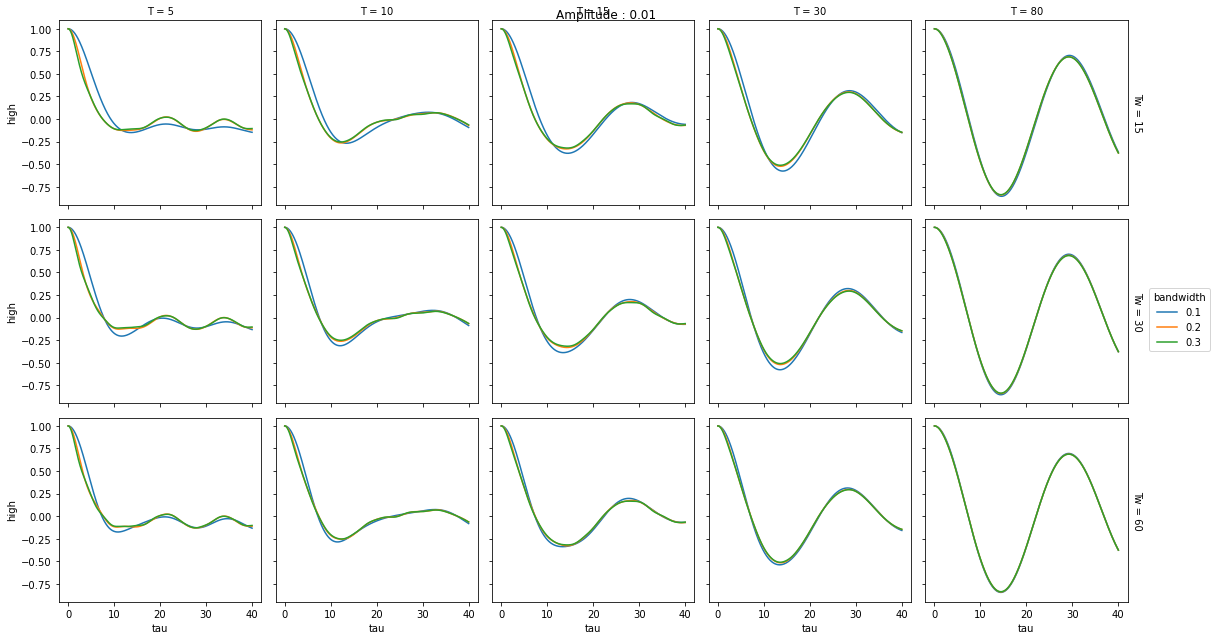

<Figure size 432x288 with 0 Axes>

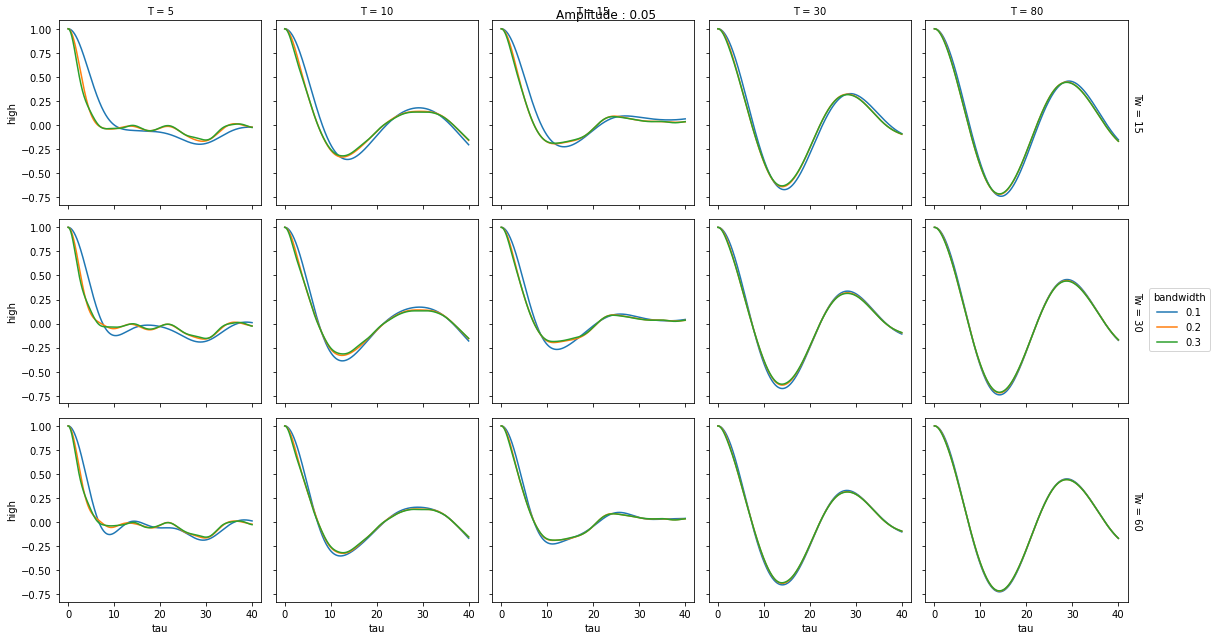

<Figure size 432x288 with 0 Axes>

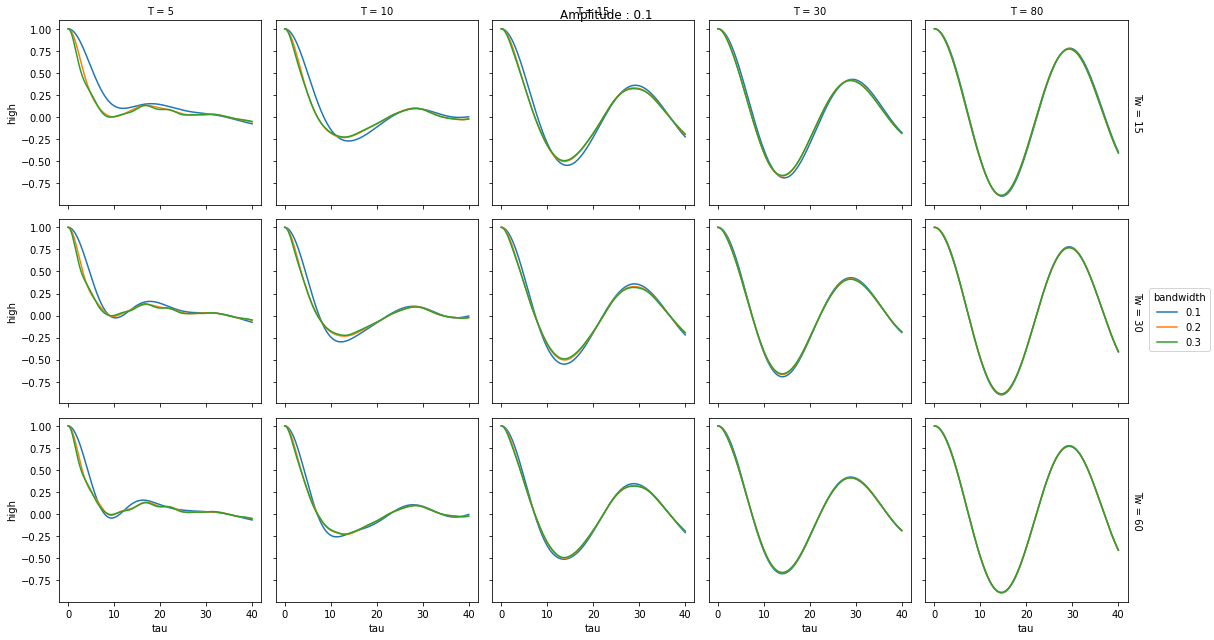

<Figure size 432x288 with 0 Axes>

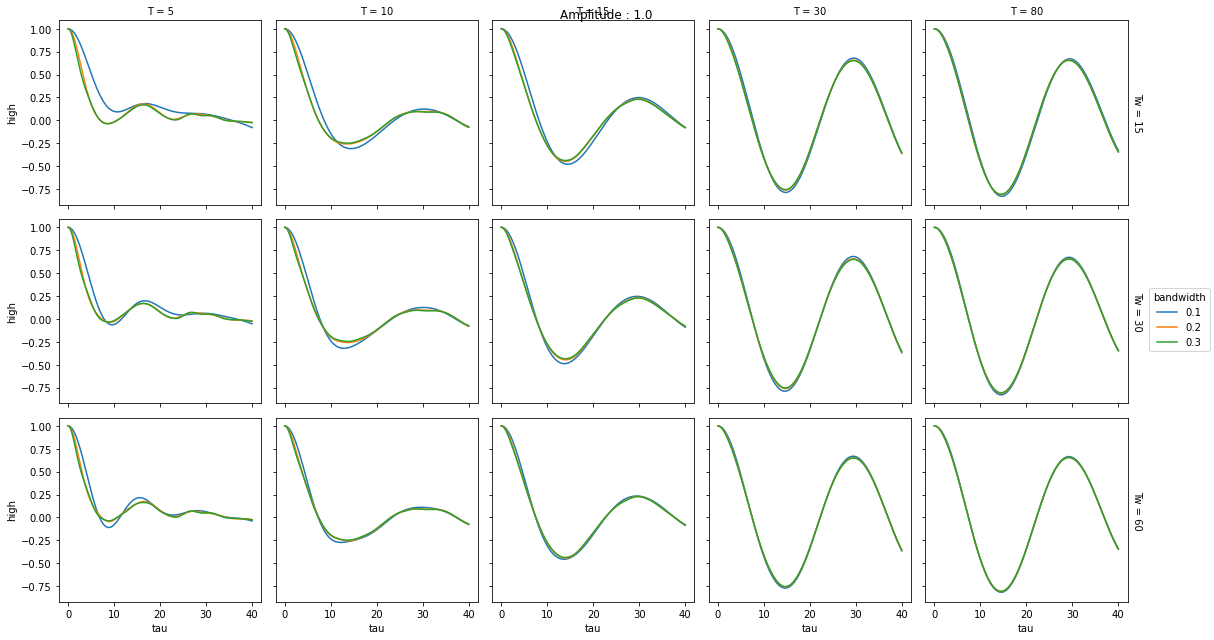

In [20]:
for U in ds_R.U_high:
    fig = plt.figure()
    (ds_R.high/ds_R.high.isel(tau=0)).sel(U_high=U).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')
    plt.suptitle('Amplitude : '+str(U.values));fig.tight_layout()
    

Notes : 

Larger kernel size decreases the dependence to the bandwidth at fixed decorrelation timescale.

For decorrelation timescale of 5 days, the spring neap cycle is not captured anymore (osclliations at shorter period appears).

Form for decorrelation timescales changes depending on the amplitude (stronger for T=5days).

NB : Here one possible explaination for oscillations of period shorter than spring neap cycle is decorrelation timescale too small compared to the cycle, no significant impact of bandwidth, etc in the observed cases (we did not test very small kernel size that could introduce new problems).

Comparison to monochromatic signal : 

The oscillations observed for $\tilde T\leq T_\omega$ observed in the monochromatic case are not observed anymore. The fact that the decorrelation timescale is shorter than the spring neap cycle seems to have a dominiant effect and creates oscillations even in cases of large enough bandwidth ($\tilde T \geq T_\omega$)

### Several draw

In [12]:
nb_draws = delta_T0
seed = 0
#T,T_low = [5,10,15,30,80],[5,15,30]
u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()
M2 = tseries("high_M2",draws=nb_draws,chunks={'draw':200,'T':-1},seed=seed).rename('M2')#,chunks={'draw':2}
S2 = tseries("high_S2",draws=nb_draws,chunks={'draw':200,'T':-1},seed=seed).rename('S2')# ,chunks={'draw':2}
#N2 = tseries("high_N2",draws=nb_draws).rename('N2')#,chunks={'draw':2}
#K2 = tseries("high_K2",draws=nb_draws).rename('K2')# ,chunks={'draw':2}
low = tseries("low",draws=nb_draws,chunks={'draw':200,'T':-1},seed=seed).rename({'T':'T_low'})#,chunks={'draw':4}

#da_high_M2 = da_high_M2.rename('high_M2')
#da_high_S2 = xr.concat([tseries("high_S2") for i in range(nb)],dim='sample'
#                      ).assign_coords({'sample':np.arange(0,nb)})
#da_high_S2 = da_high_S2.rename('high_S2')
#da_low = xr.concat([tseries("low") for i in range(nb)],dim='sample').assign_coords({'sample':np.arange(0,nb)})

In [12]:
M2.sel(draw=1).compute()

<xarray.DataArray 'M2' (T: 4, time: 12000)>
array([[ 0.03652919,  0.00295816, -0.0690608 , ...,  0.06036909,
        -0.23709986, -0.62556403],
       [-0.04401306, -0.03676896,  0.02962608, ..., -0.07674445,
         0.3215922 ,  0.73877563],
       [-0.04939688, -0.07426796, -0.10853266, ..., -0.55470668,
        -1.16885409, -1.5356013 ],
       [ 0.01143065, -0.02787285, -0.02945144, ...,  0.29987655,
         0.11982458, -0.10122823]])
Coordinates:
  * T        (T) int64 5 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
    draw     int64 1
Attributes:
    U:        [1.0]
    sigma:    12.140833182614747

In [13]:
low = low.sel(draw=M2.draw)
#M2 = M2.sel(draw=low.draw)
#S2 = S2.sel(draw=low.draw)

In [14]:
M2 = xr.concat([M2*U for U in U_high],dim='U_high').assign_coords({'U_high':U_high})
S2 = xr.concat([S2*U for U in U_high],dim='U_high').assign_coords({'U_high':U_high})

In [15]:
low = low.chunk({'time':-1})
M2 = M2.chunk({'time':-1,'U_high':-1})
S2 = S2.chunk({'time':-1,'U_high':-1})
M2

<xarray.DataArray 'M2' (U_high: 4, T: 4, time: 12000, draw: 500)>
dask.array<rechunk-merge, shape=(4, 4, 12000, 500), dtype=float64, chunksize=(4, 4, 12000, 200), chunktype=numpy.ndarray>
Coordinates:
  * T        (T) int64 5 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0

In [15]:
low

<xarray.DataArray 'low' (T_low: 3, time: 12000, draw: 500)>
dask.array<getitem, shape=(3, 12000, 500), dtype=float64, chunksize=(3, 12000, 200), chunktype=numpy.ndarray>
Coordinates:
  * T_low    (T_low) int64 5 30 100
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Attributes:
    U_low:    1.0

In [16]:
_M2,_low = xr.broadcast(M2,low)
_M2 = _M2.persist()
_low = _low.persist()

In [17]:
_S2 = xr.broadcast(_M2,S2)[1].persist()

In [18]:
_M2.sel(draw=1).compute()

<xarray.DataArray 'M2' (U_high: 4, T: 4, time: 12000, T_low: 3)>
array([[[[ 3.65291883e-04,  3.65291883e-04,  3.65291883e-04],
         [ 2.95815847e-05,  2.95815847e-05,  2.95815847e-05],
         [-6.90607980e-04, -6.90607980e-04, -6.90607980e-04],
         ...,
         [ 6.03690939e-04,  6.03690939e-04,  6.03690939e-04],
         [-2.37099863e-03, -2.37099863e-03, -2.37099863e-03],
         [-6.25564028e-03, -6.25564028e-03, -6.25564028e-03]],

        [[-4.40130625e-04, -4.40130625e-04, -4.40130625e-04],
         [-3.67689607e-04, -3.67689607e-04, -3.67689607e-04],
         [ 2.96260777e-04,  2.96260777e-04,  2.96260777e-04],
         ...,
         [-7.67444504e-04, -7.67444504e-04, -7.67444504e-04],
         [ 3.21592204e-03,  3.21592204e-03,  3.21592204e-03],
         [ 7.38775632e-03,  7.38775632e-03,  7.38775632e-03]],

        [[-4.93968751e-04, -4.93968751e-04, -4.93968751e-04],
         [-7.42679590e-04, -7.42679590e-04, -7.42679590e-04],
         [-1.08532664e-03, -1.08532664e-03, -1.08532664e-03],
         ...,
...
         ...,
         [-7.67444504e-02, -7.67444504e-02, -7.67444504e-02],
         [ 3.21592204e-01,  3.21592204e-01,  3.21592204e-01],
         [ 7.38775632e-01,  7.38775632e-01,  7.38775632e-01]],

        [[-4.93968751e-02, -4.93968751e-02, -4.93968751e-02],
         [-7.42679590e-02, -7.42679590e-02, -7.42679590e-02],
         [-1.08532664e-01, -1.08532664e-01, -1.08532664e-01],
         ...,
         [-5.54706680e-01, -5.54706680e-01, -5.54706680e-01],
         [-1.16885409e+00, -1.16885409e+00, -1.16885409e+00],
         [-1.53560130e+00, -1.53560130e+00, -1.53560130e+00]],

        [[ 1.14306475e-02,  1.14306475e-02,  1.14306475e-02],
         [-2.78728490e-02, -2.78728490e-02, -2.78728490e-02],
         [-2.94514387e-02, -2.94514387e-02, -2.94514387e-02],
         ...,
         [ 2.99876550e-01,  2.99876550e-01,  2.99876550e-01],
         [ 1.19824580e-01,  1.19824580e-01,  1.19824580e-01],
         [-1.01228226e-01, -1.01228226e-01, -1.01228226e-01]]]])
Coordinates:
  * T        (T) int64 5 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
    draw     int64 1
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * T_low    (T_low) int64 5 30 100

In [19]:
ds = xr.merge([_M2,_S2, _low]).persist()
ds

<xarray.Dataset>
Dimensions:  (T: 4, time: 12000, draw: 500, U_high: 4, T_low: 3)
Coordinates:
  * T        (T) int64 5 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * T_low    (T_low) int64 5 30 100
Data variables:
    M2       (U_high, T, time, draw, T_low) float64 dask.array<chunksize=(4, 4, 12000, 200, 3), meta=np.ndarray>
    S2       (U_high, T, time, draw, T_low) float64 dask.array<chunksize=(4, 4, 12000, 200, 3), meta=np.ndarray>
    low      (U_high, T, time, draw, T_low) float64 dask.array<chunksize=(4, 4, 12000, 200, 3), meta=np.ndarray>

In [20]:
ds.M2.sel(draw=0).compute()

<xarray.DataArray 'M2' (U_high: 4, T: 4, time: 12000, T_low: 3)>
array([[[[ 1.61035210e-03,  1.61035210e-03,  1.61035210e-03],
         [ 5.66908344e-04,  5.66908344e-04,  5.66908344e-04],
         [ 4.55386822e-04,  4.55386822e-04,  4.55386822e-04],
         ...,
         [ 1.05658832e-02,  1.05658832e-02,  1.05658832e-02],
         [ 8.20472420e-03,  8.20472420e-03,  8.20472420e-03],
         [ 5.87660081e-03,  5.87660081e-03,  5.87660081e-03]],

        [[-3.91985003e-04, -3.91985003e-04, -3.91985003e-04],
         [ 2.27927647e-04,  2.27927647e-04,  2.27927647e-04],
         [ 3.40564039e-04,  3.40564039e-04,  3.40564039e-04],
         ...,
         [-1.05682419e-02, -1.05682419e-02, -1.05682419e-02],
         [-9.79281846e-03, -9.79281846e-03, -9.79281846e-03],
         [-6.55986796e-03, -6.55986796e-03, -6.55986796e-03]],

        [[-2.43797944e-04, -2.43797944e-04, -2.43797944e-04],
         [-1.53098415e-03, -1.53098415e-03, -1.53098415e-03],
         [-1.19444300e-03, -1.19444300e-03, -1.19444300e-03],
         ...,
...
         ...,
         [-1.05682419e+00, -1.05682419e+00, -1.05682419e+00],
         [-9.79281846e-01, -9.79281846e-01, -9.79281846e-01],
         [-6.55986796e-01, -6.55986796e-01, -6.55986796e-01]],

        [[-2.43797944e-02, -2.43797944e-02, -2.43797944e-02],
         [-1.53098415e-01, -1.53098415e-01, -1.53098415e-01],
         [-1.19444300e-01, -1.19444300e-01, -1.19444300e-01],
         ...,
         [-4.03082615e-01, -4.03082615e-01, -4.03082615e-01],
         [-5.54580605e-01, -5.54580605e-01, -5.54580605e-01],
         [-5.40669371e-01, -5.40669371e-01, -5.40669371e-01]],

        [[ 3.58394654e-03,  3.58394654e-03,  3.58394654e-03],
         [ 9.44702491e-03,  9.44702491e-03,  9.44702491e-03],
         [-3.22931587e-02, -3.22931587e-02, -3.22931587e-02],
         ...,
         [ 8.05574260e-01,  8.05574260e-01,  8.05574260e-01],
         [ 2.40948858e-01,  2.40948858e-01,  2.40948858e-01],
         [-4.04653491e-01, -4.04653491e-01, -4.04653491e-01]]]])
Coordinates:
  * T        (T) int64 5 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
    draw     int64 0
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * T_low    (T_low) int64 5 30 100

In [68]:
ds = xr.broadcast(ds)[0].persist()

In [20]:
ds['high_MS'] = ds.M2+ds.S2
#ds_stat['high_MSNK'] = ds_stat.M2+ds_stat.S2+ds_stat.N2+ds_stat.K2
ds['total'] = ds.M2+ds.S2+ds.low
#ds_stat['total_NK'] = ds_stat.M2+ds_stat.S2+ds_stat.N2+ds_stat.K2+ds_stat.low

In [21]:
ds = ds.persist()

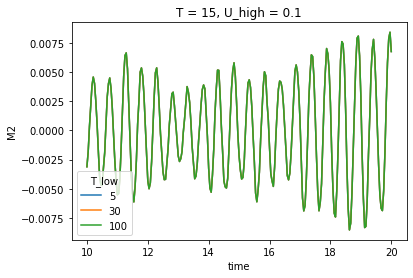

In [22]:
ds.M2.isel(T=1).sel(U_high=0.1).sel(time=slice(10,20)).mean('draw').plot(label='M2',hue='T_low')



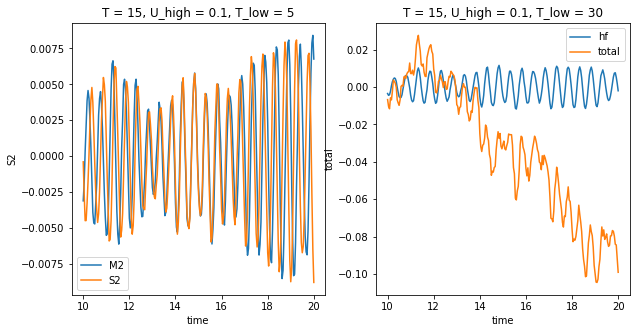

In [23]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ds.M2.isel(T=1,T_low=0).sel(U_high=0.1).sel(time=slice(10,20)).mean('draw').plot(ax=ax[0],label='M2')
ds.S2.isel(T=1,T_low=0).sel(U_high=0.1).sel(time=slice(10,20)).mean('draw').plot(ax=ax[0],label='S2')
ax[0].legend()
ds.high_MS.isel(T=1,T_low=0).sel(U_high=0.1).sel(time=slice(10,20)).mean('draw').plot(ax=ax[1],label='hf')
ds.total.isel(T_low=1,T=1,U_high=2).sel(time=slice(10,20)).mean('draw').plot(ax=ax[1],label='total')
ax[1].legend()

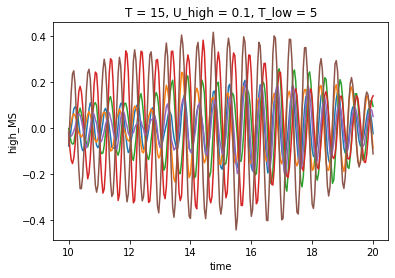

In [24]:
ds.high_MS.isel(T=1,U_high=2,T_low=0).sel(time=slice(10,20),draw=slice(0,5)).plot(hue='draw',add_legend=False)

#ds_stat.high.isel(T=1,U_high=2).sel(time=slice(100,120)).isel(draw=4).plot()

In [24]:
#Tw = [15,30,60]
#band = [0.1,0.2,0.3]
kind  = ['M2','S2','high_MS','total']
_ds_stat = {}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds_stat[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})#.compute()

In [25]:
stat = xr.merge([_ds_stat[k].drop('exp') for k in kind])

In [27]:
for k in kind:
    stat[k+'_demodulated_tmean'] = np.abs(stat[k+'_demodulated']).mean('time')
    stat[k+'_amplitude'] = np.abs(stat[k+'_demodulated'])-stat[k+'_demodulated_tmean']
    stat[k+'_var0'] = stat[k+'_amplitude']**2
    stat[k+'_var1'] = np.abs(stat[k+'_demodulated']).var('time')

In [26]:
stat

<xarray.Dataset>
Dimensions:              (Tw: 3, bandwidth: 4, U_high: 4, T: 4, time: 12000, draw: 500, T_low: 3)
Coordinates:
  * T                    (T) int64 5 15 30 80
  * time                 (time) float64 0.0 0.04167 0.08333 ... 499.9 500.0
  * draw                 (draw) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * U_high               (U_high) float64 0.01 0.05 0.1 1.0
  * T_low                (T_low) int64 5 30 100
  * Tw                   (Tw) int64 15 30 60
  * bandwidth            (bandwidth) float64 0.1 0.2 0.4 0.6
Data variables:
    M2                   (Tw, bandwidth, U_high, T, time, draw, T_low) float64 dask.array<chunksize=(1, 1, 4, 4, 12000, 200, 3), meta=np.ndarray>
    M2_bpassed           (Tw, bandwidth, U_high, T, draw, T_low, time) complex128 dask.array<chunksize=(1, 1, 4, 4, 200, 3, 12000), meta=np.ndarray>
    M2_demodulated       (Tw, bandwidth, U_high, T, draw, T_low, time) complex128 dask.array<chunksize=(1, 1, 4, 4, 200, 3, 12000), meta=np.ndarray>
    S2                   (Tw, bandwidth, U_high, T, time, draw, T_low) float64 dask.array<chunksize=(1, 1, 4, 4, 12000, 200, 3), meta=np.ndarray>
    S2_bpassed           (Tw, bandwidth, U_high, T, draw, T_low, time) complex128 dask.array<chunksize=(1, 1, 4, 4, 200, 3, 12000), meta=np.ndarray>
    S2_demodulated       (Tw, bandwidth, U_high, T, draw, T_low, time) complex128 dask.array<chunksize=(1, 1, 4, 4, 200, 3, 12000), meta=np.ndarray>
    high_MS              (Tw, bandwidth, U_high, T, time, draw, T_low) float64 dask.array<chunksize=(1, 1, 4, 4, 12000, 200, 3), meta=np.ndarray>
    high_MS_bpassed      (Tw, bandwidth, U_high, T, draw, T_low, time) complex128 dask.array<chunksize=(1, 1, 4, 4, 200, 3, 12000), meta=np.ndarray>
    high_MS_demodulated  (Tw, bandwidth, U_high, T, draw, T_low, time) complex128 dask.array<chunksize=(1, 1, 4, 4, 200, 3, 12000), meta=np.ndarray>
    total                (Tw, bandwidth, U_high, T, time, draw, T_low) float64 dask.array<chunksize=(1, 1, 4, 4, 12000, 200, 3), meta=np.ndarray>
    total_bpassed        (Tw, bandwidth, U_high, T, draw, T_low, time) complex128 dask.array<chunksize=(1, 1, 4, 4, 200, 3, 12000), meta=np.ndarray>
    total_demodulated    (Tw, bandwidth, U_high, T, draw, T_low, time) complex128 dask.array<chunksize=(1, 1, 4, 4, 200, 3, 12000), meta=np.ndarray>

In [29]:
#ds["sigma0_hat"] = u.var("time")*sigma_correction

sigma0_hat = 0.5*np.abs(stat.high_MS_demodulated)**2

In [31]:
sigma0_hat = sigma0_hat.persist()

In [32]:
sigma0_hat.to_netcdf('/home1/datawork/zcaspar/mit4320/sigma0_delta_T0.nc')

In [27]:
for k in kind:
    stat[k+'_bpassed_real'] = np.real(stat[k+'_bpassed'])
    stat[k+'_demodulated_real'] = np.real(stat[k+'_demodulated'])
stat = stat.persist()

In [28]:
stat_mean = {}
for k in kind : 
    stat_mean[k+'_var'] = stat[k].var('time').mean('draw')
#    stat_mean[k+'_mean'] = stat[k].mean(['time','draw'])
    stat_mean[k+'_bpassed_var'] = stat[k+'_bpassed_real'].var('time').mean('draw')
#    stat_mean[k+'_bpassed_mean'] = stat[k+'_bpassed_real'].mean(['time','draw'])
    stat_mean[k+'_demodulated_var'] = stat[k+'_demodulated_real'].var('time').mean('draw')
    stat_mean[k+'_demodulated_energy'] = (np.abs(stat[k+'_demodulated'])**2).mean(['time','draw'])
#    stat_mean[k+'_demodulated_mean'] = stat[k+'_demodulated_real'].mean(['time','draw'])
#    stat_mean = stat_mean.persist()
#    stat_mean[k+'_demodulated_var'] = np.abs(stat[k+'_demodulated']).mean(['time','draw'])
#    stat_mean[k+'_var0'] = stat[k+'_var0'].mean(['time','draw'])
#    stat_mean[k+'_var1'] = stat[k+'_var1'].mean('draw')

In [29]:
stat_mean.keys()

dict_keys(['M2_var', 'M2_bpassed_var', 'M2_demodulated_var', 'M2_demodulated_energy', 'S2_var', 'S2_bpassed_var', 'S2_demodulated_var', 'S2_demodulated_energy', 'high_MS_var', 'high_MS_bpassed_var', 'high_MS_demodulated_var', 'high_MS_demodulated_energy', 'total_var', 'total_bpassed_var', 'total_demodulated_var', 'total_demodulated_energy'])

In [30]:
mstat = xr.merge([stat_mean[key].rename(key) for key in stat_mean.keys()]).persist()

In [31]:
mstat

<xarray.Dataset>
Dimensions:                     (T: 4, U_high: 5, T_low: 3, Tw: 3, bandwidth: 4)
Coordinates:
  * T                           (T) int64 5 15 30 80
  * U_high                      (U_high) float64 0.01 0.05 0.1 1.0 2.0
  * T_low                       (T_low) int64 5 30 100
  * Tw                          (Tw) int64 15 30 60
  * bandwidth                   (bandwidth) float64 0.1 0.2 0.4 0.6
Data variables: (12/16)
    M2_var                      (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    M2_bpassed_var              (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    M2_demodulated_var          (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    M2_demodulated_energy       (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    S2_var                      (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    S2_bpassed_var              (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    ...                          ...
    high_MS_demodulated_var     (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    high_MS_demodulated_energy  (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    total_var                   (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    total_bpassed_var           (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    total_demodulated_var       (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    total_demodulated_energy    (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>

<Figure size 432x288 with 0 Axes>

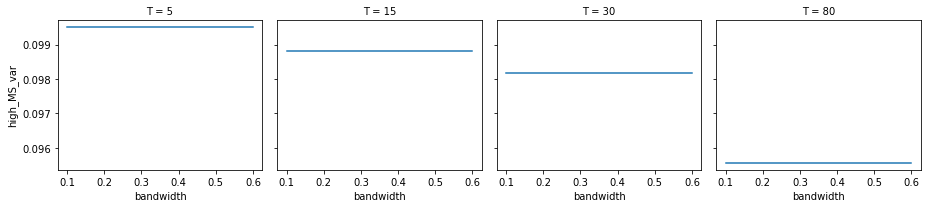

<Figure size 432x288 with 0 Axes>

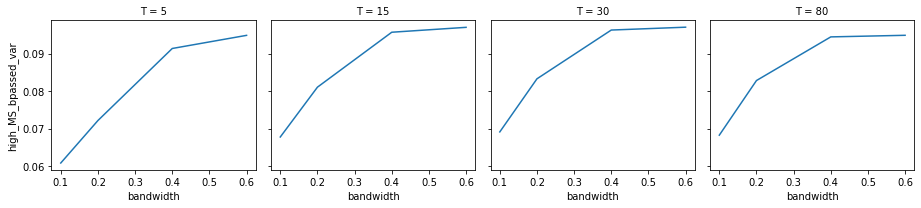

<Figure size 432x288 with 0 Axes>

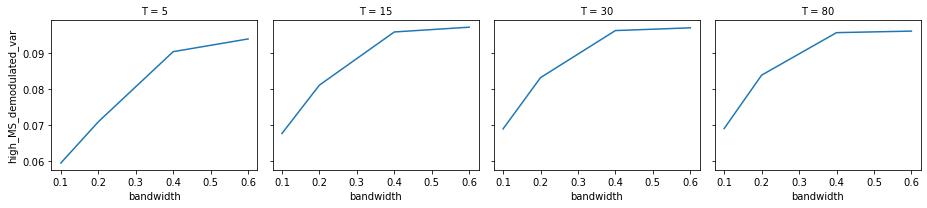

In [31]:
#mstat.sel(U_high=0.1,Tw=15,T_low=30).high_MS_mean.plot(col='T')
plt.figure()
np.sqrt(mstat.sel(U_high=0.1,Tw=15,T_low=30)).high_MS_var.plot(col='T')
plt.figure()
np.sqrt(mstat.sel(U_high=0.1,Tw=15,T_low=30)).high_MS_bpassed_var.plot(col='T')
plt.figure()
np.sqrt(mstat.sel(U_high=0.1,Tw=15,T_low=30)).high_MS_demodulated_var.plot(col='T')

In [33]:
mstat.to_netcdf('/home1/datawork/zcaspar/mit4320/variance_delta_T0.nc')

In [34]:
del mstat

In [35]:
stat_mean = {}
for k in kind : 
    stat_mean[k+'_mean'] = stat[k].mean(['time','draw'])
    stat_mean[k+'_bpassed_mean'] = stat[k+'_bpassed_real'].mean(['time','draw'])
    stat_mean[k+'_demodulated_mean'] = stat[k+'_demodulated_real'].mean(['time','draw'])

In [36]:
mstat = xr.merge([stat_mean[key].rename(key) for key in stat_mean.keys()]).persist()

In [37]:
mstat.to_netcdf('/home1/datawork/zcaspar/mit4320/mean_delta_T0.nc')

In [45]:
for k in kind:
    _ds_stat[k] = _ds_stat[k].sel(time=slice(0,80)).persist()

In [87]:
R_stat = {}
maxlag = t_size
lags = np.arange(0,maxlag//2,1/24)
for k in kind:
    R_stat[k] = autocorrelations(_ds_stat[k],[k],maxlag=maxlag,lags = lags,**{'mode':'valid'})

/home1/datahome/zcaspar/synthetic_stats/sstats/sigp.py:126: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,
/home1/datahome/zcaspar/synthetic_stats/sstats/sigp.py:126: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,
/home1/datahome/zcaspar/synthetic_stats/sstats/sigp.py:126: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,
/home1/datahome/zcaspar/synthetic_stats/sstats/sigp.py:126: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,


In [88]:
ds_R_stat = xr.merge([R_stat[k] for k in kind]) #,'total'

In [90]:
del stat_mean

In [ ]:
xr.merge([ds_R_stat,R_low])

In [91]:
ds_R_mean = ds_R_stat.mean('draw')

In [92]:
ds_R_mean = ds_R_mean.persist()

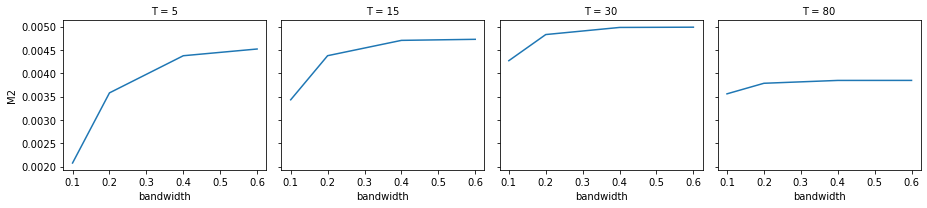

In [50]:
ds_R_mean.sel(tau=0,U_high=0.1,Tw=30,T_low=5).M2.plot(col='T')

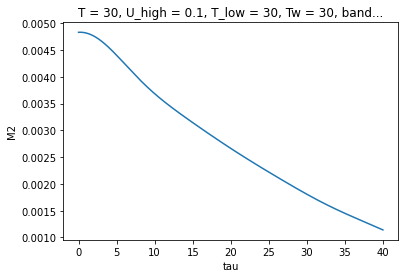

In [51]:
ds_R_mean.sel(T=30,Tw=30,U_high=0.1,bandwidth=0.2,T_low=30).M2.sel(tau=slice(0,40)).plot()

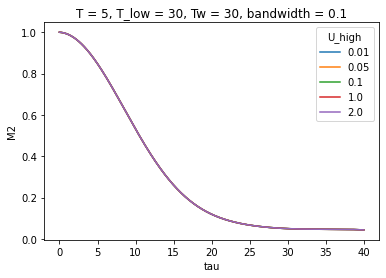

<Figure size 432x288 with 0 Axes>

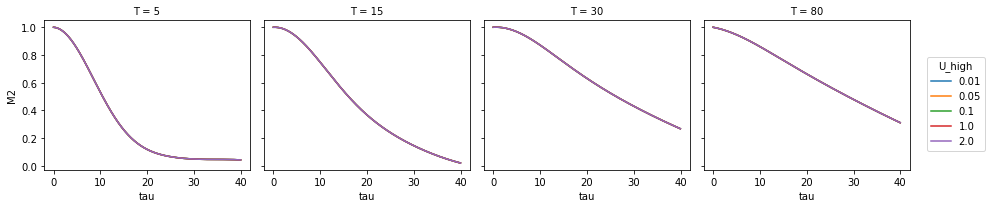

<Figure size 432x288 with 0 Axes>

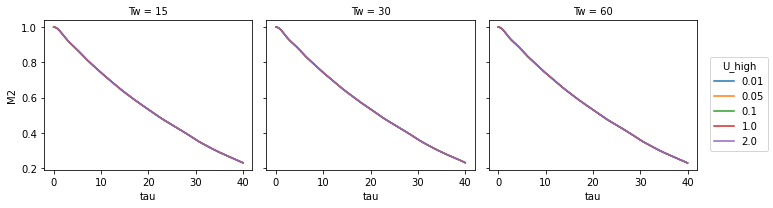

<Figure size 432x288 with 0 Axes>

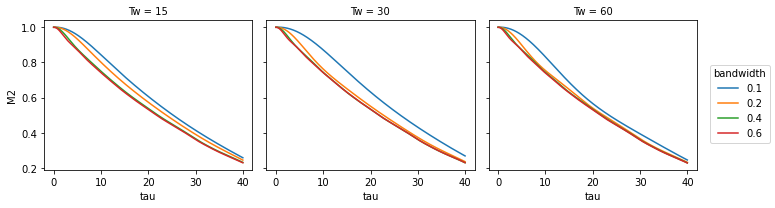

In [52]:
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(bandwidth=0.1,T=5,Tw=30,T_low=30).plot(hue='U_high')
plt.figure()
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(bandwidth=0.1,Tw=30,T_low=30).plot(hue='U_high',col='T')

plt.figure()
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(bandwidth=0.6,T=30,T_low=30).plot(hue='U_high',col='Tw')

plt.figure()
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(T=30,U_high=0.1,T_low=30).plot(hue='bandwidth',col='Tw')

In [53]:
ds_R_mean = ds_R_mean.compute()

In [54]:
ds_R_mean.to_netcdf('/home1/datawork/zcaspar/mit4320/synthetic_delta_T0_U_valid_80.nc')

In [40]:
[_ds_stat[_].drop('exp') for _ in _ds_stat.keys()]

[<xarray.Dataset>
 Dimensions:         (Tw: 3, bandwidth: 4, T: 5, time: 1920, draw: 1000, U_high: 4, T_low: 3)
 Coordinates:
   * T               (T) int64 5 10 15 30 80
   * time            (time) float64 0.0 0.04167 0.08333 ... 79.88 79.92 79.96
   * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
   * U_high          (U_high) float64 0.01 0.05 0.1 1.0
   * T_low           (T_low) int64 5 30 100
   * Tw              (Tw) int64 15 30 60
   * bandwidth       (bandwidth) float64 0.1 0.2 0.4 0.6
 Data variables:
     M2              (Tw, bandwidth, T, time, draw, U_high, T_low) float64 dask.array<chunksize=(1, 1, 5, 1920, 1000, 1, 3), meta=np.ndarray>
     M2_bpassed      (Tw, bandwidth, T, draw, U_high, T_low, time) complex128 dask.array<chunksize=(1, 1, 5, 1000, 1, 3, 1920), meta=np.ndarray>
     M2_demodulated  (Tw, bandwidth, T, draw, U_high, T_low, time) complex128 dask.array<chunksize=(1, 1, 5, 1000, 1, 3, 1920), meta=np.ndarray>,
 <xarray.Dataset>
 Di

In [29]:
_ds_stat = xr.merge([_ds_stat[_].drop('exp') for _ in _ds_stat.keys()])

In [30]:
for k in kind:
    _ds_stat[k+'_bpassed_real'] = _ds_stat[k+'_bpassed'].real
    _ds_stat[k+'_bpassed_imag'] = _ds_stat[k+'_bpassed'].imag
    _ds_stat[k+'_demodulated_real'] = _ds_stat[k+'_demodulated'].real
    _ds_stat[k+'_demodulated_imag'] = _ds_stat[k+'_demodulated'].imag
    _ds_stat = _ds_stat.drop([k+'_bpassed',k+'_demodulated'])
_ds_stat = _ds_stat.persist()

In [ ]:
_ds_stat.to_netcdf('/home1/datawork/zcaspar/mit4320/filtered_1000_T80.nc')

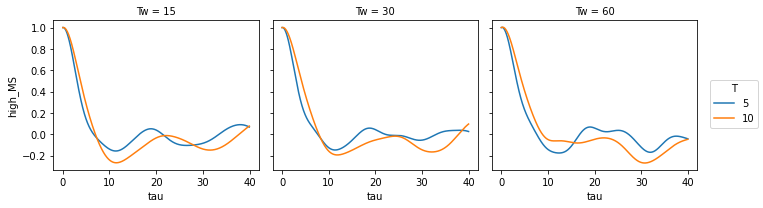

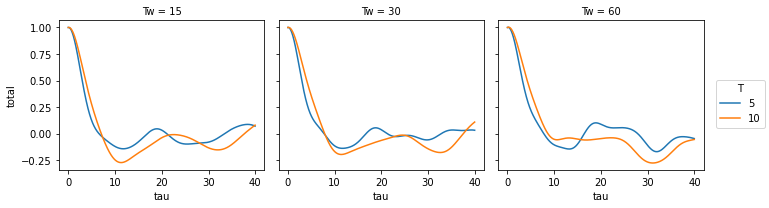

In [35]:
(ds_R_mean['high_MS']/ds_R_mean['high_MS'].isel(tau=0)).sel(U_high=0.1,T_low=30,bandwidth=0.4).sel(tau=slice(0,40)).sel(T=slice(5,10)).plot(hue='T',col='Tw')

(ds_R_mean['total']/ds_R_mean['total'].isel(tau=0)).sel(U_high=0.1,T_low=30,bandwidth=0.4).sel(tau=slice(0,40)).sel(T=slice(5,10)).plot(hue='T',col='Tw')

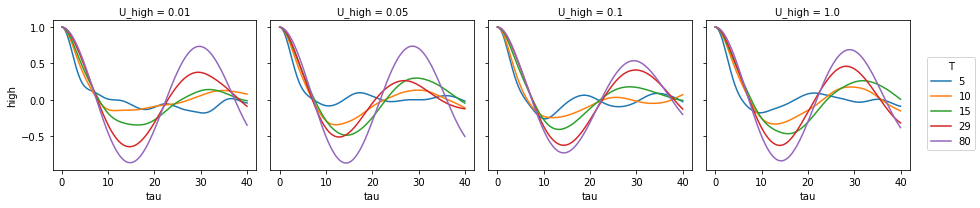

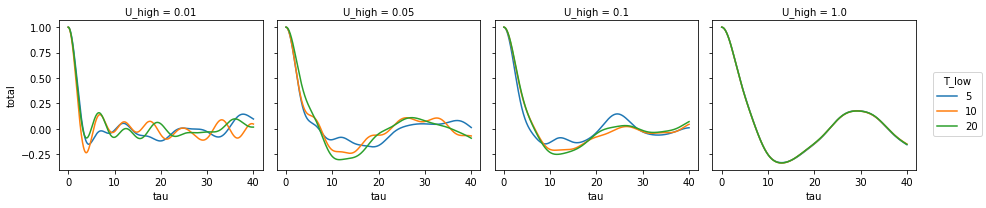

In [96]:
(ds_R['high']/ds_R['high'].isel(tau=0)).sel(Tw=30).sel(tau=slice(0,40)).plot(hue='T',col='U_high')
(ds_R['total']/ds_R['total'].isel(tau=0)).sel(T=10,Tw=30).sel(tau=slice(0,40)).plot(hue='T_low',col='U_high')

In [44]:
#client.restart()
#
cluster.close()

tornado.application - ERROR - Exception in callback functools.partial(<function TCPServer._handle_connection.<locals>.<lambda> at 0x2aabd313e430>, <Task finished name='Task-2103' coro=<BaseTCPListener._handle_stream() done, defined at /home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/comm/tcp.py:513> exception=ValueError('invalid operation on non-started TCPListener')>)
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/tornado/tcpserver.py", line 331, in <lambda>
    gen.convert_yielded(future), lambda f: f.result()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/comm/tcp.py", line 519, in _handle_stream
    logger.debug("Incoming connection from %r to %r", address, self.contact_address)
  Fi